In [1]:
import pandas as pd
from sklearn.utils import shuffle
import math
import numpy as np
import seaborn as sns
import tensorflow as tf
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

df = pd.read_csv('fraud_order_classifier.csv')

### imputeMissingvalue()

3 Global Variables required for this function, which are declared later in the notebook.

replacedata_userid = {userid1:{col1: val11, col2: val12, ....},
                      userid2:{col1: val21, col2: val22, ....}, 
                      ........}
replacedata_city = {city1:{col1: val11, col2: val12, ....},
                    city2:{col1: val21, col2: val22, ....}, 
                    ........}
replacedata = {col1: val1, col2: val2, ....}

Purpose: Impute missing values of the columns passed through 'cols'. Priority by (user_id, 'city' and generic)


In [2]:
def imputeMissingvalue(df, cols):
    for r in df.iterrows():
        index = r[0]
        
        for col in cols:
            if math.isnan(df.loc[index][col]):
                userid = df.loc[index]['user_id']
                city = df.loc[index]['city']
                v = replacedata_userid.get(userid, replacedata_city.get(city))
                if v is None:
                    v = replacedata.get(col)
                else:
                    v = v.get(col)
                df.at[index, col] = v
    
    return df

                

### calculateOtherGroupMember()

Helper re-usuable function for transferring categorical columns to numerical columns. The idea is not have a separate column for every possible value within a categorical column. Instead I will have a reference fraction and within a categorical column if a value appear atleast certain number(total length of the reference data * reference fraction) of times that value will be eligible to have a separate column for itself. The values which do not qualify, will be grouped together as 'others'.

In [3]:
def calculateOtherGroupMember(df, attribute, minP):
    individual = []
    others = []
    tmp = df[attribute].value_counts()
    total = tmp.sum()
    lowerLimit = total * minP
    for i in list(tmp.index):
        if tmp.loc[i] < lowerLimit:
            others.append(i)
        else:
            individual.append(i)
    return individual, others

### bundleTransform()
Re-usable function to add one-hot encoded columns to the dataset based on individual and others logic defined at calculateOtherGroupMember().       

In [4]:
def bundleTransform(df, originalcol, individual, others):
    newcols = []
    for i in individual:
        df[originalcol+'_'+str(i)] = df[originalcol].apply(lambda x: 1 if x == i else 0)
        newcols.append(originalcol+'_'+str(i))
    if not others is None and len(others)>0:
        df[originalcol+'_'+'others'] = df[originalcol].apply(lambda x: 1 if x in others else 0)
        newcols.append(originalcol+'_'+'others')
    return df, newcols

### featureColCalculations()
Re-usable function to get all the feature columns together.

In [5]:
def featureColCalculations(columnsForNomalization, oneHotEncodedCols):
    catcols = []
    for k in oneHotEncodedCols:
        individualCols = oneHotEncodedCols[k]['individual']
        for v in individualCols:
            catcols.append(k + '_' + v)
        others = oneHotEncodedCols[k]['others']
        if not others is None and len(others)>0:
            catcols.append(k + '_' + 'others')
            
    featureCols = columnsForNomalization + catcols
    return featureCols

    

### plot_cm()
Re-usable function to plot the confusion matrix. 

In [6]:
def plot_cm(labels, predictions, p=0.5):
    cm = confusion_matrix(labels, predictions > p)
    plt.figure(figsize=(5,5))
    sns.heatmap(cm, annot=True, fmt="d")
    plt.title('Confusion matrix @{:.2f}'.format(p))
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')

    print('Legitimate Transactions Detected (True Negatives): ', cm[0][0])
    print('Legitimate Transactions Incorrectly Detected (False Positives): ', cm[0][1])
    print('Fraudulent Transactions Missed (False Negatives): ', cm[1][0])
    print('Fraudulent Transactions Detected (True Positives): ', cm[1][1])
    print('Total Fraudulent Transactions: ', np.sum(cm[1]))

### plot_metrics()
Reusable function to plot the 'loss', 'auc', 'precision' and 'recall' for training and validation set during the training process by epoch.

In [7]:
def plot_metrics(history):
    metrics =  ['loss', 'auc', 'precision', 'recall']
    plt.figure(figsize=(16,9))
    for n, metric in enumerate(metrics):
        name = metric.replace("_"," ").capitalize()
        plt.subplot(2,2,n+1)
        plt.plot(history.epoch,  history.history[metric], color=colors[0], label='Train')
        plt.plot(history.epoch, history.history['val_'+metric],
                 color=colors[0], linestyle="--", label='Val')
        plt.xlabel('Epoch')
        plt.ylabel(name)
        if metric == 'loss':
            plt.ylim([0, plt.ylim()[1]])
        elif metric == 'auc':
            plt.ylim([0.8,1])
        else:
            plt.ylim([0,1])

        plt.legend()


### BinaryClassification

The Model class.

In [8]:
class BinaryClassification(tf.keras.Model):
    def __init__(self, units, output_bias=None):
        super(BinaryClassification, self).__init__()
        if output_bias is None:
            output_bias = 0
        self.output_bias = tf.keras.initializers.Constant(output_bias)
        self.dense = tf.keras.layers.Dense(units, activation='relu')
        self.dropout = tf.keras.layers.Dropout(0.5)
        self.final = tf.keras.layers.Dense(1, activation='sigmoid', bias_initializer=self.output_bias)
    def call(self, inputs):
        x = self.dense(inputs)
        x = self.dropout(x)
        x = self.final(x)
        return x

### calcDays()

Calculate number of days passed since an account is opened and the respective order is placed from that account.

In [9]:
def calcDays(x):
    return (x['order_date'] - x['user_account_created_date']).days


## Exploratory Data Analysis

In [10]:
df.isna().sum()

order_id                            0
product_id                          0
quantity                            0
selling_price                       0
order_date                          0
shipping_type                       0
user_id                             0
user_account_created_date           0
address_id                          0
city                                0
pincode                             0
phone                               0
vertical                            0
discount                            0
count_14_days                       0
count_28_days                       0
count_56_days                       0
category_purchase_count_bks     19204
category_purchase_count_X4kt    19204
category_purchase_count_X4rr    19204
category_purchase_count_dep     19204
category_purchase_count_kyh     19204
category_purchase_count_mgl     19204
category_purchase_count_dgv     19204
category_purchase_count_ixq     19204
category_purchase_count_X26x    19204
category_pur

In [11]:
columns = ['category_purchase_count_bks',     
'category_purchase_count_X4kt',  
'category_purchase_count_X4rr',    
'category_purchase_count_dep',   
'category_purchase_count_kyh',     
'category_purchase_count_mgl',     
'category_purchase_count_dgv',     
'category_purchase_count_ixq',     
'category_purchase_count_X26x',    
'category_purchase_count_t06',     
'category_purchase_count_amz',     
'category_purchase_count_reh',     
'category_purchase_count_ckf',     
'category_purchase_count_j9e',     
'category_purchase_count_jek',     
'category_purchase_count_tyy',     
'category_purchase_count_vdm',     
'category_purchase_count_X6bo',    
'category_purchase_count_X2oq',    
'category_purchase_count_mcr',     
'category_purchase_count_osp',     
'category_purchase_count_r18']     


### Calculating global variable, which will be used to replace missing values.

In [12]:
df_replacedata_userid = pd.DataFrame(df.dropna().groupby(by=['user_id'])[columns].median())
df_replacedata_city = pd.DataFrame(df.dropna().groupby(by=['city'])[columns].median())

replacedata_userid = df_replacedata_userid.to_dict(orient='index')
replacedata_city = df_replacedata_city.to_dict(orient='index')

df_replacedata= pd.DataFrame(df.dropna())[columns].median()
replacedata = df_replacedata.to_dict()

In [13]:
data = imputeMissingvalue(df.copy(), columns)

In [14]:
labelBinary = {'normal': 0 , 'fraud': 1}
data['labelBinary'] = data['label'].apply(lambda x: labelBinary.get(x))

In [15]:
neg, pos = np.bincount(data['labelBinary'])
total = neg + pos
print('Examples:\n    Total: {}\n    Positive: {} ({:.2f}% of total)\n'.format(
    total, pos, 100 * pos / total))

Examples:
    Total: 481107
    Positive: 22080 (4.59% of total)



In [16]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
quantity,481107.0,1.077401,0.367006,1.0,1.000,1.0,1.000,10.000
selling_price,481107.0,4327.573053,7047.851746,1.0,214.000,559.0,6999.000,152955.000
discount,481107.0,15.413950,13.376370,0.0,1.946,14.0,24.738,69.944
count_14_days,481107.0,24.710054,162.501839,1.0,1.000,1.0,3.000,3072.000
count_28_days,481107.0,24.710054,162.501839,1.0,1.000,1.0,3.000,3072.000
count_56_days,481107.0,24.710054,162.501839,1.0,1.000,1.0,3.000,3072.000
category_purchase_count_bks,481107.0,585.912141,4448.617508,0.0,0.000,5.0,26.000,227262.000
category_purchase_count_X4kt,481107.0,0.934105,10.739684,0.0,0.000,0.0,0.000,1195.000
category_purchase_count_X4rr,481107.0,0.605462,21.154451,0.0,0.000,0.0,0.000,1554.000
category_purchase_count_dep,481107.0,0.165931,1.364643,0.0,0.000,0.0,0.000,191.000


### Transforming some of the values in log space, which have larger range.

In [17]:
logColumns = ['selling_price', 'count_14_days', 'count_28_days', 'count_56_days']
eps=0.001 # 0 => 0.1¢
for c in logColumns:
    data['log_{}'.format(c)] = np.log(data.pop(c)+eps)

In [18]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
quantity,481107.0,1.077401,0.367006,1.000,1.000000,1.000000,1.000000,10.000000
discount,481107.0,15.413950,13.376370,0.000,1.946000,14.000000,24.738000,69.944000
category_purchase_count_bks,481107.0,585.912141,4448.617508,0.000,0.000000,5.000000,26.000000,227262.000000
category_purchase_count_X4kt,481107.0,0.934105,10.739684,0.000,0.000000,0.000000,0.000000,1195.000000
category_purchase_count_X4rr,481107.0,0.605462,21.154451,0.000,0.000000,0.000000,0.000000,1554.000000
category_purchase_count_dep,481107.0,0.165931,1.364643,0.000,0.000000,0.000000,0.000000,191.000000
category_purchase_count_kyh,481107.0,0.184947,2.117467,0.000,0.000000,0.000000,0.000000,206.000000
category_purchase_count_mgl,481107.0,0.320157,3.231206,0.000,0.000000,0.000000,0.000000,299.000000
category_purchase_count_dgv,481107.0,0.406961,3.958059,0.000,0.000000,0.000000,0.000000,520.000000
category_purchase_count_ixq,481107.0,0.175821,3.258871,0.000,0.000000,0.000000,0.000000,422.000000


In [19]:
data['user_account_created_date'] = pd.to_datetime(data['user_account_created_date'])
data['order_date'] = pd.to_datetime(data['order_date'])

data['daysPassed'] = data[['order_date','user_account_created_date']].apply(lambda x: calcDays(x), axis=1)

In [20]:
data['daysPassed'].describe()

count    481107.000000
mean        455.195505
std         451.266797
min          -1.000000
25%          26.000000
50%         349.000000
75%         772.000000
max        3437.000000
Name: daysPassed, dtype: float64

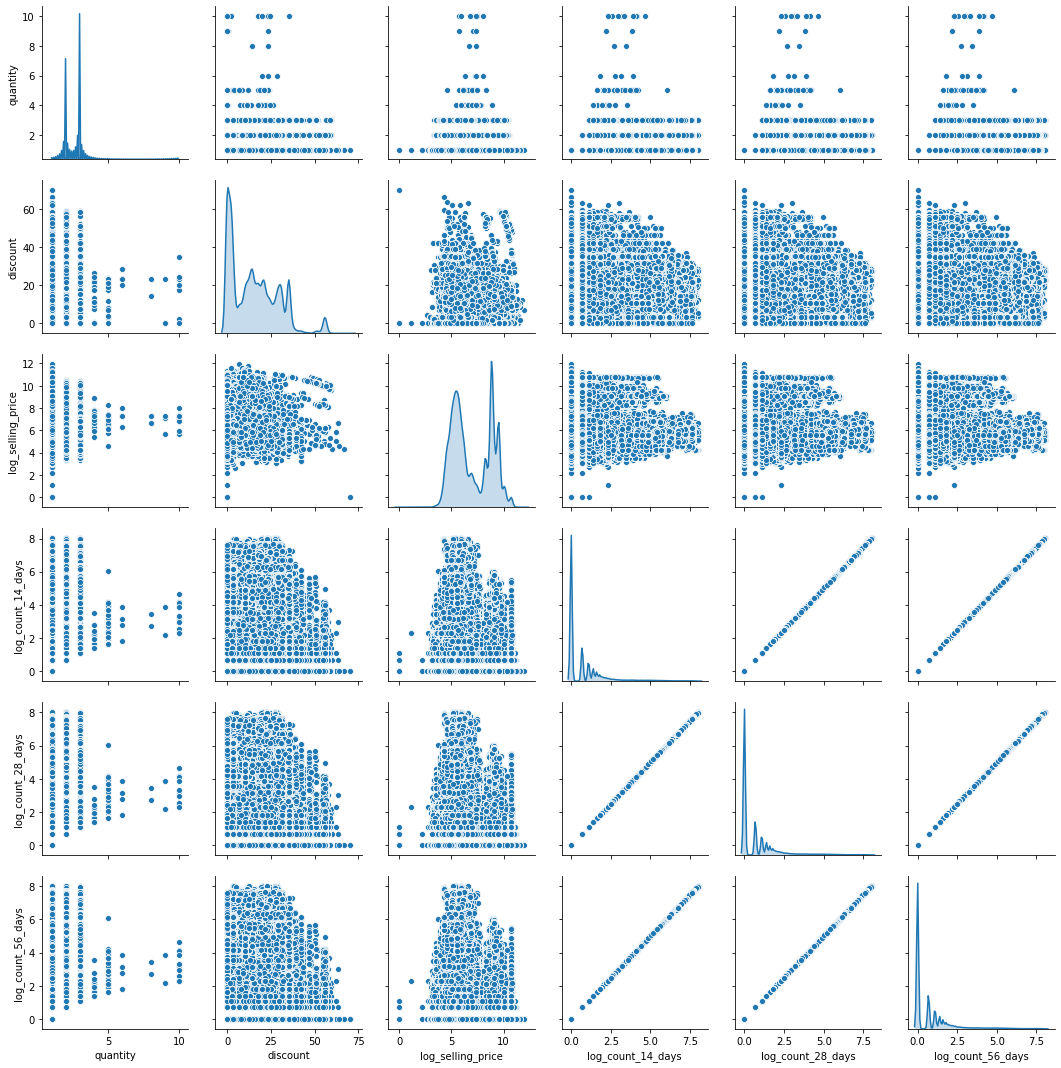

In [21]:

sns.pairplot(data[["quantity", "discount", "log_selling_price", "log_count_14_days",
                   "log_count_28_days", "log_count_56_days"]], diag_kind="kde")

In [22]:
data = shuffle(data)
train_dataset = data.sample(frac=0.8,random_state=0)
test_dataset = data.drop(train_dataset.index)

In [23]:
data.columns

Index(['order_id', 'product_id', 'quantity', 'order_date', 'shipping_type',
       'user_id', 'user_account_created_date', 'address_id', 'city', 'pincode',
       'phone', 'vertical', 'discount', 'category_purchase_count_bks',
       'category_purchase_count_X4kt', 'category_purchase_count_X4rr',
       'category_purchase_count_dep', 'category_purchase_count_kyh',
       'category_purchase_count_mgl', 'category_purchase_count_dgv',
       'category_purchase_count_ixq', 'category_purchase_count_X26x',
       'category_purchase_count_t06', 'category_purchase_count_amz',
       'category_purchase_count_reh', 'category_purchase_count_ckf',
       'category_purchase_count_j9e', 'category_purchase_count_jek',
       'category_purchase_count_tyy', 'category_purchase_count_vdm',
       'category_purchase_count_X6bo', 'category_purchase_count_X2oq',
       'category_purchase_count_mcr', 'category_purchase_count_osp',
       'category_purchase_count_r18', 'label', 'labelBinary',
       'log_sell

In [24]:
columnsForNomalization = ['quantity', 'discount', 'category_purchase_count_bks',
       'category_purchase_count_X4kt', 'category_purchase_count_X4rr',
       'category_purchase_count_dep', 'category_purchase_count_kyh',
       'category_purchase_count_mgl', 'category_purchase_count_dgv',
       'category_purchase_count_ixq', 'category_purchase_count_X26x',
       'category_purchase_count_t06', 'category_purchase_count_amz',
       'category_purchase_count_reh', 'category_purchase_count_ckf',
       'category_purchase_count_j9e', 'category_purchase_count_jek',
       'category_purchase_count_tyy', 'category_purchase_count_vdm',
       'category_purchase_count_X6bo', 'category_purchase_count_X2oq',
       'category_purchase_count_mcr', 'category_purchase_count_osp',
       'category_purchase_count_r18', 'log_selling_price', 'log_count_14_days',
        'log_count_28_days', 'log_count_56_days', 'daysPassed']


train_stats = train_dataset[columnsForNomalization].describe()
train_stats = train_stats.transpose()
train_stats

,count,mean,std,min,25%,50%,75%,max
quantity,384886.0,1.076960,0.365793,1.000,1.000000,1.000000,1.000000,10.000000
discount,384886.0,15.404796,13.364558,0.000,1.946000,14.000000,24.738000,69.944000
category_purchase_count_bks,384886.0,583.723977,4480.720432,0.000,0.000000,5.000000,26.000000,227262.000000
category_purchase_count_X4kt,384886.0,0.949595,11.242169,0.000,0.000000,0.000000,0.000000,1195.000000
category_purchase_count_X4rr,384886.0,0.624134,21.811152,0.000,0.000000,0.000000,0.000000,1554.000000
category_purchase_count_dep,384886.0,0.166951,1.382611,0.000,0.000000,0.000000,0.000000,191.000000
category_purchase_count_kyh,384886.0,0.188238,2.163476,0.000,0.000000,0.000000,0.000000,206.000000
category_purchase_count_mgl,384886.0,0.319734,3.236264,0.000,0.000000,0.000000,0.000000,299.000000
category_purchase_count_dgv,384886.0,0.411997,4.064141,0.000,0.000000,0.000000,0.000000,520.000000
category_purchase_count_ixq,384886.0,0.180865,3.300195,0.000,0.000000,0.000000,0.000000,422.000000


### Z-score normalization of data

In [25]:
train_stats_norma = train_stats.to_dict(orient='index')

In [26]:
for c in columnsForNomalization:
    mean_c = train_stats_norma.get(c).get('mean')
    std_c = train_stats_norma.get(c).get('std')
    train_dataset[c] = (train_dataset[c]-mean_c)/(std_c+eps)

In [27]:
for c in columnsForNomalization:
    mean_c = train_stats_norma.get(c).get('mean')
    std_c = train_stats_norma.get(c).get('std')
    test_dataset[c] = (test_dataset[c]-mean_c)/(std_c+eps)

In [28]:

print ("Total positive(Fraud Transaction) examples: {},\n\
Total negative(Legitimate Transactions) examples: {}".format(pos, neg))


Total positive(Fraud Transaction) examples: 22080,
Total negative(Legitimate Transactions) examples: 459027


### Defining the Metrics which I will be tracking to estimate model performance

In [29]:
METRICS = [
      tf.keras.metrics.TruePositives(name='tp'),
      tf.keras.metrics.FalsePositives(name='fp'),
      tf.keras.metrics.TrueNegatives(name='tn'),
      tf.keras.metrics.FalseNegatives(name='fn'), 
      tf.keras.metrics.BinaryAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall'),
      tf.keras.metrics.AUC(name='auc'),
]


In [30]:
train_dataset.columns

Index(['order_id', 'product_id', 'quantity', 'order_date', 'shipping_type',
       'user_id', 'user_account_created_date', 'address_id', 'city', 'pincode',
       'phone', 'vertical', 'discount', 'category_purchase_count_bks',
       'category_purchase_count_X4kt', 'category_purchase_count_X4rr',
       'category_purchase_count_dep', 'category_purchase_count_kyh',
       'category_purchase_count_mgl', 'category_purchase_count_dgv',
       'category_purchase_count_ixq', 'category_purchase_count_X26x',
       'category_purchase_count_t06', 'category_purchase_count_amz',
       'category_purchase_count_reh', 'category_purchase_count_ckf',
       'category_purchase_count_j9e', 'category_purchase_count_jek',
       'category_purchase_count_tyy', 'category_purchase_count_vdm',
       'category_purchase_count_X6bo', 'category_purchase_count_X2oq',
       'category_purchase_count_mcr', 'category_purchase_count_osp',
       'category_purchase_count_r18', 'label', 'labelBinary',
       'log_sell

In [31]:
train_dataset['shipping_type'].value_counts()

non-ndd    357643
ndd         27243
Name: shipping_type, dtype: int64

In [32]:
len(train_dataset['vertical'].value_counts())

45

In [33]:
len(test_dataset['vertical'].value_counts())

46

### Handling Categorical variables in a scalable way. 

In [34]:
individual, others = calculateOtherGroupMember(df = train_dataset.copy(), attribute = 'vertical', minP = 0.01)

In [35]:
train_dataset, newcols = bundleTransform(df=train_dataset,
                                         originalcol='vertical', individual=individual, others=others)

In [36]:
test_dataset, newcols = bundleTransform(df=test_dataset,
                                         originalcol='vertical', individual=individual, others=others)

In [37]:
oneHotEncodedCols = {'vertical':{'individual': individual, 'others': others}}

In [38]:
individual, others = calculateOtherGroupMember(df = train_dataset.copy(), attribute = 'shipping_type', minP = 0.01)

In [39]:
train_dataset, newcols = bundleTransform(df=train_dataset,
                                         originalcol='shipping_type', individual=individual, others=others)

In [40]:
test_dataset, newcols = bundleTransform(df=test_dataset,
                                         originalcol='shipping_type', individual=individual, others=others)

In [41]:
oneHotEncodedCols['shipping_type'] = {'individual': individual, 'others': others}

In [42]:
featureCols = featureColCalculations(columnsForNomalization, oneHotEncodedCols)

In [43]:
val_dataset = train_dataset.sample(frac=0.2,random_state=0)

In [44]:
val_dataset.shape

(76977, 53)

In [45]:
train_dataset.shape

(384886, 53)

### Base Model

In [46]:
trainX = train_dataset[featureCols].values
trainY = train_dataset['labelBinary'].values
trainX, trainY = shuffle(trainX, trainY)


valX = val_dataset[featureCols].values
valY = val_dataset['labelBinary'].values

testX = test_dataset[featureCols].values
testY = test_dataset['labelBinary'].values

In [47]:
EPOCHS = 500
BATCH_SIZE = 2048

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_auc', 
    verbose=1,
    patience=10,
    mode='max',
    restore_best_weights=True)

filepath = './checkpoints_monitorValPrecision_base_model/my_checkpoint'

# monitorValAccuracy = tf.keras.callbacks.ModelCheckpoint(
#                     filepath, monitor='val_Accuracy', verbose=1, save_best_only=True,
#                     save_weights_only=True, mode='max', save_freq='epoch')

monitorValPrecision = tf.keras.callbacks.ModelCheckpoint(
                    filepath, monitor='val_precision', verbose=1, save_best_only=True,
                    save_weights_only=True, mode='max', save_freq='epoch')



In [48]:
base_model = BinaryClassification(units=32)

base_model.compile(optimizer=tf.keras.optimizers.Adam(lr=1e-3),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=METRICS)

base_history = base_model.fit(
    trainX,
    trainY,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=(valX, valY), 
    verbose=1, 
    callbacks = [early_stopping, monitorValPrecision])

Epoch 1/500
187/188 [============================>.] - ETA: 0s - loss: 0.2768 - tp: 1557.0000 - fp: 11905.0000 - tn: 353529.0000 - fn: 15985.0000 - accuracy: 0.9272 - precision: 0.1157 - recall: 0.0888 - auc: 0.6662
Epoch 00001: val_precision improved from -inf to 0.88554, saving model to ./checkpoints_monitorValPrecision_base_model/my_checkpoint
188/188 [==============================] - 1s 7ms/step - loss: 0.2762 - tp: 1567.0000 - fp: 11909.0000 - tn: 355363.0000 - fn: 16047.0000 - accuracy: 0.9274 - precision: 0.1163 - recall: 0.0890 - auc: 0.6671 - val_loss: 0.1279 - val_tp: 441.0000 - val_fp: 57.0000 - val_tn: 73378.0000 - val_fn: 3101.0000 - val_accuracy: 0.9590 - val_precision: 0.8855 - val_recall: 0.1245 - val_auc: 0.8940
Epoch 2/500
187/188 [============================>.] - ETA: 0s - loss: 0.1375 - tp: 4734.0000 - fp: 1731.0000 - tn: 363726.0000 - fn: 12785.0000 - accuracy: 0.9621 - precision: 0.7323 - recall: 0.2702 - auc: 0.8654
Epoch 00002: val_precision improved from 0.88

176/188 [===========================>..] - ETA: 0s - loss: 0.1034 - tp: 7110.0000 - fp: 1713.0000 - tn: 342229.0000 - fn: 9396.0000 - accuracy: 0.9692 - precision: 0.8058 - recall: 0.4308 - auc: 0.9212
Epoch 00013: val_precision did not improve from 0.89514
188/188 [==============================] - 1s 4ms/step - loss: 0.1034 - tp: 7592.0000 - fp: 1832.0000 - tn: 365440.0000 - fn: 10022.0000 - accuracy: 0.9692 - precision: 0.8056 - recall: 0.4310 - auc: 0.9210 - val_loss: 0.0929 - val_tp: 1563.0000 - val_fp: 316.0000 - val_tn: 73119.0000 - val_fn: 1979.0000 - val_accuracy: 0.9702 - val_precision: 0.8318 - val_recall: 0.4413 - val_auc: 0.9358
Epoch 14/500
184/188 [============================>.] - ETA: 0s - loss: 0.1028 - tp: 7519.0000 - fp: 1784.0000 - tn: 357798.0000 - fn: 9731.0000 - accuracy: 0.9694 - precision: 0.8082 - recall: 0.4359 - auc: 0.9203
Epoch 00014: val_precision did not improve from 0.89514
188/188 [==============================] - 1s 4ms/step - loss: 0.1027 - tp: 767

Epoch 26/500
175/188 [==========================>...] - ETA: 0s - loss: 0.0995 - tp: 6941.0000 - fp: 1558.0000 - tn: 340408.0000 - fn: 9493.0000 - accuracy: 0.9692 - precision: 0.8167 - recall: 0.4224 - auc: 0.9260
Epoch 00026: val_precision did not improve from 0.89514
188/188 [==============================] - 1s 4ms/step - loss: 0.0992 - tp: 7457.0000 - fp: 1658.0000 - tn: 365614.0000 - fn: 10157.0000 - accuracy: 0.9693 - precision: 0.8181 - recall: 0.4234 - auc: 0.9266 - val_loss: 0.0910 - val_tp: 1586.0000 - val_fp: 297.0000 - val_tn: 73138.0000 - val_fn: 1956.0000 - val_accuracy: 0.9707 - val_precision: 0.8423 - val_recall: 0.4478 - val_auc: 0.9386
Epoch 27/500
185/188 [============================>.] - ETA: 0s - loss: 0.0990 - tp: 7374.0000 - fp: 1608.0000 - tn: 359924.0000 - fn: 9974.0000 - accuracy: 0.9694 - precision: 0.8210 - recall: 0.4251 - auc: 0.9258
Epoch 00027: val_precision did not improve from 0.89514
188/188 [==============================] - 1s 4ms/step - loss: 0.0

Epoch 39/500
174/188 [==========================>...] - ETA: 0s - loss: 0.0971 - tp: 6893.0000 - fp: 1515.0000 - tn: 338463.0000 - fn: 9481.0000 - accuracy: 0.9691 - precision: 0.8198 - recall: 0.4210 - auc: 0.9312
Epoch 00039: val_precision did not improve from 0.89514
188/188 [==============================] - 1s 4ms/step - loss: 0.0967 - tp: 7418.0000 - fp: 1631.0000 - tn: 365641.0000 - fn: 10196.0000 - accuracy: 0.9693 - precision: 0.8198 - recall: 0.4211 - auc: 0.9310 - val_loss: 0.0899 - val_tp: 1560.0000 - val_fp: 247.0000 - val_tn: 73188.0000 - val_fn: 1982.0000 - val_accuracy: 0.9710 - val_precision: 0.8633 - val_recall: 0.4404 - val_auc: 0.9405
Epoch 40/500
179/188 [===========================>..] - ETA: 0s - loss: 0.0971 - tp: 6968.0000 - fp: 1445.0000 - tn: 348372.0000 - fn: 9807.0000 - accuracy: 0.9693 - precision: 0.8282 - recall: 0.4154 - auc: 0.9303
Epoch 00040: val_precision did not improve from 0.89514
188/188 [==============================] - 1s 4ms/step - loss: 0.0

Epoch 52/500
176/188 [===========================>..] - ETA: 0s - loss: 0.0960 - tp: 6953.0000 - fp: 1508.0000 - tn: 342435.0000 - fn: 9552.0000 - accuracy: 0.9693 - precision: 0.8218 - recall: 0.4213 - auc: 0.9325
Epoch 00052: val_precision did not improve from 0.89514
188/188 [==============================] - 1s 4ms/step - loss: 0.0960 - tp: 7437.0000 - fp: 1602.0000 - tn: 365670.0000 - fn: 10177.0000 - accuracy: 0.9694 - precision: 0.8228 - recall: 0.4222 - auc: 0.9321 - val_loss: 0.0889 - val_tp: 1588.0000 - val_fp: 265.0000 - val_tn: 73170.0000 - val_fn: 1954.0000 - val_accuracy: 0.9712 - val_precision: 0.8570 - val_recall: 0.4483 - val_auc: 0.9423
Epoch 53/500
185/188 [============================>.] - ETA: 0s - loss: 0.0959 - tp: 7357.0000 - fp: 1565.0000 - tn: 359948.0000 - fn: 10010.0000 - accuracy: 0.9694 - precision: 0.8246 - recall: 0.4236 - auc: 0.9324
Epoch 00053: val_precision did not improve from 0.89514
188/188 [==============================] - 1s 4ms/step - loss: 0.

Epoch 65/500
188/188 [==============================] - ETA: 0s - loss: 0.0955 - tp: 7519.0000 - fp: 1535.0000 - tn: 365737.0000 - fn: 10095.0000 - accuracy: 0.9698 - precision: 0.8305 - recall: 0.4269 - auc: 0.9329
Epoch 00065: val_precision did not improve from 0.89514
188/188 [==============================] - 1s 4ms/step - loss: 0.0955 - tp: 7519.0000 - fp: 1535.0000 - tn: 365737.0000 - fn: 10095.0000 - accuracy: 0.9698 - precision: 0.8305 - recall: 0.4269 - auc: 0.9329 - val_loss: 0.0882 - val_tp: 1601.0000 - val_fp: 270.0000 - val_tn: 73165.0000 - val_fn: 1941.0000 - val_accuracy: 0.9713 - val_precision: 0.8557 - val_recall: 0.4520 - val_auc: 0.9427
Epoch 66/500
173/188 [==========================>...] - ETA: 0s - loss: 0.0958 - tp: 6789.0000 - fp: 1417.0000 - tn: 336662.0000 - fn: 9436.0000 - accuracy: 0.9694 - precision: 0.8273 - recall: 0.4184 - auc: 0.9330
Epoch 00066: val_precision did not improve from 0.89514
188/188 [==============================] - 1s 4ms/step - loss: 0.

Epoch 78/500
187/188 [============================>.] - ETA: 0s - loss: 0.0952 - tp: 7491.0000 - fp: 1555.0000 - tn: 363908.0000 - fn: 10022.0000 - accuracy: 0.9698 - precision: 0.8281 - recall: 0.4277 - auc: 0.9330
Epoch 00078: val_precision did not improve from 0.89514
188/188 [==============================] - 1s 4ms/step - loss: 0.0953 - tp: 7532.0000 - fp: 1558.0000 - tn: 365714.0000 - fn: 10082.0000 - accuracy: 0.9698 - precision: 0.8286 - recall: 0.4276 - auc: 0.9330 - val_loss: 0.0880 - val_tp: 1574.0000 - val_fp: 257.0000 - val_tn: 73178.0000 - val_fn: 1968.0000 - val_accuracy: 0.9711 - val_precision: 0.8596 - val_recall: 0.4444 - val_auc: 0.9433
Epoch 79/500
187/188 [============================>.] - ETA: 0s - loss: 0.0952 - tp: 7530.0000 - fp: 1545.0000 - tn: 363911.0000 - fn: 9990.0000 - accuracy: 0.9699 - precision: 0.8298 - recall: 0.4298 - auc: 0.9334
Epoch 00079: val_precision did not improve from 0.89514
188/188 [==============================] - 1s 4ms/step - loss: 0.

Epoch 91/500
185/188 [============================>.] - ETA: 0s - loss: 0.0949 - tp: 7428.0000 - fp: 1501.0000 - tn: 360027.0000 - fn: 9924.0000 - accuracy: 0.9698 - precision: 0.8319 - recall: 0.4281 - auc: 0.9338
Epoch 00091: val_precision did not improve from 0.89514
188/188 [==============================] - 1s 4ms/step - loss: 0.0950 - tp: 7540.0000 - fp: 1524.0000 - tn: 365748.0000 - fn: 10074.0000 - accuracy: 0.9699 - precision: 0.8319 - recall: 0.4281 - auc: 0.9336 - val_loss: 0.0879 - val_tp: 1561.0000 - val_fp: 240.0000 - val_tn: 73195.0000 - val_fn: 1981.0000 - val_accuracy: 0.9711 - val_precision: 0.8667 - val_recall: 0.4407 - val_auc: 0.9438
Epoch 92/500
181/188 [===========================>..] - ETA: 0s - loss: 0.0946 - tp: 7233.0000 - fp: 1451.0000 - tn: 352304.0000 - fn: 9700.0000 - accuracy: 0.9699 - precision: 0.8329 - recall: 0.4272 - auc: 0.9339
Epoch 00092: val_precision did not improve from 0.89514
188/188 [==============================] - 1s 4ms/step - loss: 0.0

Epoch 104/500
175/188 [==========================>...] - ETA: 0s - loss: 0.0950 - tp: 7012.0000 - fp: 1465.0000 - tn: 340519.0000 - fn: 9404.0000 - accuracy: 0.9697 - precision: 0.8272 - recall: 0.4271 - auc: 0.9334
Epoch 00104: val_precision did not improve from 0.89514
188/188 [==============================] - 1s 4ms/step - loss: 0.0949 - tp: 7546.0000 - fp: 1572.0000 - tn: 365700.0000 - fn: 10068.0000 - accuracy: 0.9698 - precision: 0.8276 - recall: 0.4284 - auc: 0.9337 - val_loss: 0.0877 - val_tp: 1566.0000 - val_fp: 241.0000 - val_tn: 73194.0000 - val_fn: 1976.0000 - val_accuracy: 0.9712 - val_precision: 0.8666 - val_recall: 0.4421 - val_auc: 0.9442
Epoch 105/500
185/188 [============================>.] - ETA: 0s - loss: 0.0949 - tp: 7483.0000 - fp: 1482.0000 - tn: 360071.0000 - fn: 9844.0000 - accuracy: 0.9701 - precision: 0.8347 - recall: 0.4319 - auc: 0.9331
Epoch 00105: val_precision did not improve from 0.89514
188/188 [==============================] - 1s 4ms/step - loss: 0

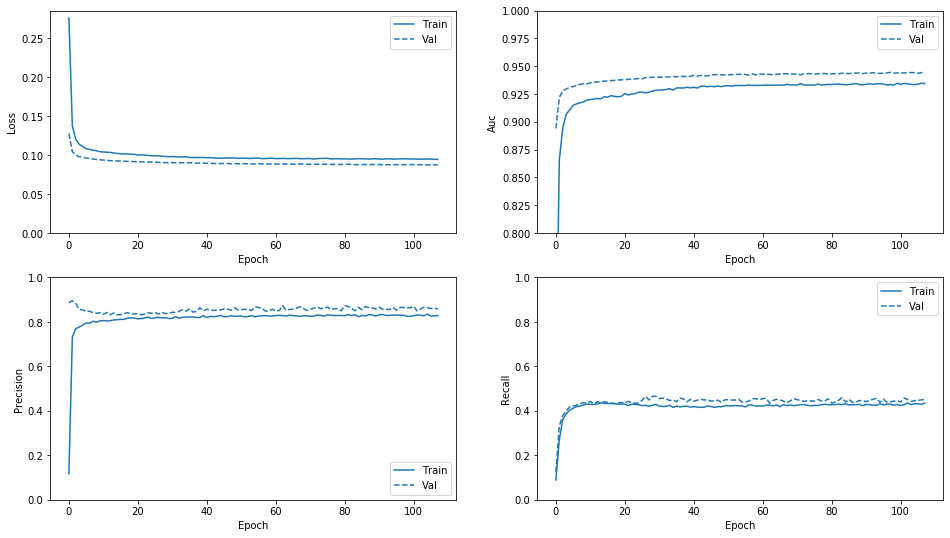

In [56]:
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
plot_metrics(base_history)

In [51]:
base_model.evaluate(testX, testY)

3007/3007 [==============================] - 2s 718us/step - loss: 0.1082 - tp: 1474.0000 - fp: 177.0000 - tn: 91578.0000 - fn: 2992.0000 - accuracy: 0.9671 - precision: 0.8928 - recall: 0.3300 - auc: 0.9167


[0.10815230756998062,
 1474.0,
 177.0,
 91578.0,
 2992.0,
 0.9670653939247131,
 0.8927922248840332,
 0.3300492465496063,
 0.9167089462280273]

Legitimate Transactions Detected (True Negatives):  91578
Legitimate Transactions Incorrectly Detected (False Positives):  177
Fraudulent Transactions Missed (False Negatives):  2992
Fraudulent Transactions Detected (True Positives):  1474
Total Fraudulent Transactions:  4466


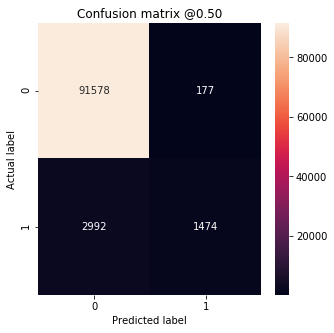

In [52]:
testPredictions = base_model.predict(testX)
plot_cm(testY, testPredictions)

In [53]:
base_model.load_weights(filepath)
base_model.evaluate(testX, testY)

3007/3007 [==============================] - 2s 693us/step - loss: 0.1082 - tp: 1474.0000 - fp: 177.0000 - tn: 91578.0000 - fn: 2992.0000 - accuracy: 0.9671 - precision: 0.8928 - recall: 0.3300 - auc: 0.9167


[0.10815230756998062,
 1474.0,
 177.0,
 91578.0,
 2992.0,
 0.9670653939247131,
 0.8927922248840332,
 0.3300492465496063,
 0.9167089462280273]

In [54]:
testPredictions = base_model.predict(testX)

Legitimate Transactions Detected (True Negatives):  91578
Legitimate Transactions Incorrectly Detected (False Positives):  177
Fraudulent Transactions Missed (False Negatives):  2992
Fraudulent Transactions Detected (True Positives):  1474
Total Fraudulent Transactions:  4466


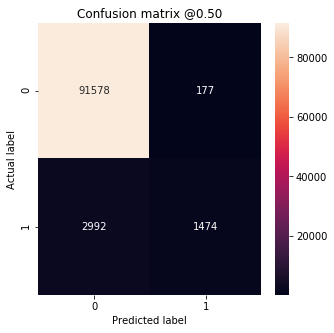

In [55]:
plot_cm(testY, testPredictions)

## Setting Bias of the Model Explicitly

### Setting the Bias for Un-balanced class
Note: The positive class is under-represented.

$$ p_0 = pos/(pos + neg) = 1/(1+e^{-b_0}) $$
$$ b_0 = -log_e(1/p_0 - 1) $$
$$ b_0 = log_e(pos/neg)$$

In [57]:
pos/(pos + neg)

0.045894156601338165

In [58]:
initial_bias = np.log([pos/neg])
initial_bias

array([-3.03443681])

In [59]:
EPOCHS = 500
BATCH_SIZE = 2048

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_auc', 
    verbose=1,
    patience=10,
    mode='max',
    restore_best_weights=True)

filepath = './checkpoints_monitorValPrecision_modelWithBias/my_checkpoint'

# monitorValAccuracy = tf.keras.callbacks.ModelCheckpoint(
#                     filepath, monitor='val_Accuracy', verbose=1, save_best_only=True,
#                     save_weights_only=True, mode='max', save_freq='epoch')

monitorValPrecision = tf.keras.callbacks.ModelCheckpoint(
                    filepath, monitor='val_precision', verbose=1, save_best_only=True,
                    save_weights_only=True, mode='max', save_freq='epoch')



In [60]:
modelWithBias = BinaryClassification(units=32, output_bias=initial_bias)
modelWithBias.compile(optimizer=tf.keras.optimizers.Adam(lr=1e-3),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=METRICS)

In [61]:
history = modelWithBias.fit(
    trainX,
    trainY,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=(valX, valY), 
    verbose=1, 
    callbacks = [early_stopping, monitorValPrecision])

Epoch 1/500
181/188 [===========================>..] - ETA: 0s - loss: 0.1701 - tp: 2178.0000 - fp: 1616.0000 - tn: 443869.0000 - fn: 19246.0000 - accuracy: 0.9553 - precision: 0.5741 - recall: 0.1017 - auc: 0.8159
Epoch 00001: val_precision improved from -inf to 0.93098, saving model to ./checkpoints_monitorValPrecision_modelWithBias/my_checkpoint
188/188 [==============================] - 1s 7ms/step - loss: 0.1686 - tp: 2276.0000 - fp: 1652.0000 - tn: 457375.0000 - fn: 19804.0000 - accuracy: 0.9554 - precision: 0.5794 - recall: 0.1031 - auc: 0.8185 - val_loss: 0.1165 - val_tp: 634.0000 - val_fp: 47.0000 - val_tn: 73388.0000 - val_fn: 2908.0000 - val_accuracy: 0.9616 - val_precision: 0.9310 - val_recall: 0.1790 - val_auc: 0.9179
Epoch 2/500
186/188 [============================>.] - ETA: 0s - loss: 0.1208 - tp: 4234.0000 - fp: 1224.0000 - tn: 362279.0000 - fn: 13191.0000 - accuracy: 0.9622 - precision: 0.7757 - recall: 0.2430 - auc: 0.8975
Epoch 00002: val_precision did not improve f

174/188 [==========================>...] - ETA: 0s - loss: 0.0997 - tp: 6315.0000 - fp: 1463.0000 - tn: 338633.0000 - fn: 9941.0000 - accuracy: 0.9680 - precision: 0.8119 - recall: 0.3885 - auc: 0.9284
Epoch 00013: val_precision did not improve from 0.93098
188/188 [==============================] - 1s 4ms/step - loss: 0.0998 - tp: 6849.0000 - fp: 1581.0000 - tn: 365691.0000 - fn: 10765.0000 - accuracy: 0.9679 - precision: 0.8125 - recall: 0.3888 - auc: 0.9285 - val_loss: 0.0919 - val_tp: 1420.0000 - val_fp: 216.0000 - val_tn: 73219.0000 - val_fn: 2122.0000 - val_accuracy: 0.9696 - val_precision: 0.8680 - val_recall: 0.4009 - val_auc: 0.9392
Epoch 14/500
178/188 [===========================>..] - ETA: 0s - loss: 0.0994 - tp: 6534.0000 - fp: 1495.0000 - tn: 346370.0000 - fn: 10145.0000 - accuracy: 0.9681 - precision: 0.8138 - recall: 0.3918 - auc: 0.9283
Epoch 00014: val_precision did not improve from 0.93098
188/188 [==============================] - 1s 4ms/step - loss: 0.0995 - tp: 68

Epoch 26/500
174/188 [==========================>...] - ETA: 0s - loss: 0.0970 - tp: 6702.0000 - fp: 1482.0000 - tn: 338579.0000 - fn: 9589.0000 - accuracy: 0.9689 - precision: 0.8189 - recall: 0.4114 - auc: 0.9317
Epoch 00026: val_precision did not improve from 0.93098
188/188 [==============================] - 1s 4ms/step - loss: 0.0969 - tp: 7225.0000 - fp: 1608.0000 - tn: 365664.0000 - fn: 10389.0000 - accuracy: 0.9688 - precision: 0.8180 - recall: 0.4102 - auc: 0.9322 - val_loss: 0.0894 - val_tp: 1522.0000 - val_fp: 234.0000 - val_tn: 73201.0000 - val_fn: 2020.0000 - val_accuracy: 0.9707 - val_precision: 0.8667 - val_recall: 0.4297 - val_auc: 0.9419
Epoch 27/500
178/188 [===========================>..] - ETA: 0s - loss: 0.0972 - tp: 6937.0000 - fp: 1513.0000 - tn: 346303.0000 - fn: 9791.0000 - accuracy: 0.9690 - precision: 0.8209 - recall: 0.4147 - auc: 0.9308
Epoch 00027: val_precision did not improve from 0.93098
188/188 [==============================] - 1s 4ms/step - loss: 0.0

Epoch 39/500
174/188 [==========================>...] - ETA: 0s - loss: 0.0955 - tp: 6844.0000 - fp: 1540.0000 - tn: 338543.0000 - fn: 9425.0000 - accuracy: 0.9692 - precision: 0.8163 - recall: 0.4207 - auc: 0.9336
Epoch 00039: val_precision did not improve from 0.93098
188/188 [==============================] - 1s 4ms/step - loss: 0.0956 - tp: 7399.0000 - fp: 1665.0000 - tn: 365607.0000 - fn: 10215.0000 - accuracy: 0.9691 - precision: 0.8163 - recall: 0.4201 - auc: 0.9335 - val_loss: 0.0883 - val_tp: 1572.0000 - val_fp: 240.0000 - val_tn: 73195.0000 - val_fn: 1970.0000 - val_accuracy: 0.9713 - val_precision: 0.8675 - val_recall: 0.4438 - val_auc: 0.9438
Epoch 40/500
176/188 [===========================>..] - ETA: 0s - loss: 0.0957 - tp: 6971.0000 - fp: 1527.0000 - tn: 342490.0000 - fn: 9460.0000 - accuracy: 0.9695 - precision: 0.8203 - recall: 0.4243 - auc: 0.9329
Epoch 00040: val_precision did not improve from 0.93098
188/188 [==============================] - 1s 4ms/step - loss: 0.0

Epoch 52/500
187/188 [============================>.] - ETA: 0s - loss: 0.0952 - tp: 7422.0000 - fp: 1635.0000 - tn: 363823.0000 - fn: 10096.0000 - accuracy: 0.9694 - precision: 0.8195 - recall: 0.4237 - auc: 0.9340
Epoch 00052: val_precision did not improve from 0.93098
188/188 [==============================] - 1s 4ms/step - loss: 0.0953 - tp: 7458.0000 - fp: 1641.0000 - tn: 365631.0000 - fn: 10156.0000 - accuracy: 0.9693 - precision: 0.8197 - recall: 0.4234 - auc: 0.9339 - val_loss: 0.0876 - val_tp: 1613.0000 - val_fp: 229.0000 - val_tn: 73206.0000 - val_fn: 1929.0000 - val_accuracy: 0.9720 - val_precision: 0.8757 - val_recall: 0.4554 - val_auc: 0.9446
Epoch 53/500
175/188 [==========================>...] - ETA: 0s - loss: 0.0951 - tp: 7019.0000 - fp: 1593.0000 - tn: 340356.0000 - fn: 9432.0000 - accuracy: 0.9692 - precision: 0.8150 - recall: 0.4267 - auc: 0.9354
Epoch 00053: val_precision did not improve from 0.93098
188/188 [==============================] - 1s 4ms/step - loss: 0.

Epoch 65/500
186/188 [============================>.] - ETA: 0s - loss: 0.0952 - tp: 7430.0000 - fp: 1624.0000 - tn: 361883.0000 - fn: 9991.0000 - accuracy: 0.9695 - precision: 0.8206 - recall: 0.4265 - auc: 0.9340
Epoch 00065: val_precision did not improve from 0.93098
188/188 [==============================] - 1s 4ms/step - loss: 0.0952 - tp: 7506.0000 - fp: 1639.0000 - tn: 365633.0000 - fn: 10108.0000 - accuracy: 0.9695 - precision: 0.8208 - recall: 0.4261 - auc: 0.9340 - val_loss: 0.0874 - val_tp: 1626.0000 - val_fp: 254.0000 - val_tn: 73181.0000 - val_fn: 1916.0000 - val_accuracy: 0.9718 - val_precision: 0.8649 - val_recall: 0.4591 - val_auc: 0.9450
Epoch 66/500
176/188 [===========================>..] - ETA: 0s - loss: 0.0956 - tp: 7026.0000 - fp: 1616.0000 - tn: 342294.0000 - fn: 9512.0000 - accuracy: 0.9691 - precision: 0.8130 - recall: 0.4248 - auc: 0.9340
Epoch 00066: val_precision did not improve from 0.93098
188/188 [==============================] - 1s 4ms/step - loss: 0.0

Epoch 78/500
173/188 [==========================>...] - ETA: 0s - loss: 0.0949 - tp: 6906.0000 - fp: 1454.0000 - tn: 336687.0000 - fn: 9257.0000 - accuracy: 0.9698 - precision: 0.8261 - recall: 0.4273 - auc: 0.9341
Epoch 00078: val_precision did not improve from 0.93098
188/188 [==============================] - 1s 4ms/step - loss: 0.0948 - tp: 7536.0000 - fp: 1602.0000 - tn: 365670.0000 - fn: 10078.0000 - accuracy: 0.9697 - precision: 0.8247 - recall: 0.4278 - auc: 0.9347 - val_loss: 0.0869 - val_tp: 1680.0000 - val_fp: 262.0000 - val_tn: 73173.0000 - val_fn: 1862.0000 - val_accuracy: 0.9724 - val_precision: 0.8651 - val_recall: 0.4743 - val_auc: 0.9452
Epoch 79/500
186/188 [============================>.] - ETA: 0s - loss: 0.0950 - tp: 7517.0000 - fp: 1646.0000 - tn: 361851.0000 - fn: 9914.0000 - accuracy: 0.9697 - precision: 0.8204 - recall: 0.4312 - auc: 0.9344
Epoch 00079: val_precision did not improve from 0.93098
188/188 [==============================] - 1s 4ms/step - loss: 0.0

Epoch 91/500
183/188 [============================>.] - ETA: 0s - loss: 0.0950 - tp: 7406.0000 - fp: 1655.0000 - tn: 355975.0000 - fn: 9748.0000 - accuracy: 0.9696 - precision: 0.8173 - recall: 0.4317 - auc: 0.9345
Epoch 00091: val_precision did not improve from 0.93098
188/188 [==============================] - 1s 4ms/step - loss: 0.0950 - tp: 7593.0000 - fp: 1688.0000 - tn: 365584.0000 - fn: 10021.0000 - accuracy: 0.9696 - precision: 0.8181 - recall: 0.4311 - auc: 0.9345 - val_loss: 0.0869 - val_tp: 1615.0000 - val_fp: 221.0000 - val_tn: 73214.0000 - val_fn: 1927.0000 - val_accuracy: 0.9721 - val_precision: 0.8796 - val_recall: 0.4560 - val_auc: 0.9451
Epoch 92/500
175/188 [==========================>...] - ETA: 0s - loss: 0.0948 - tp: 7027.0000 - fp: 1527.0000 - tn: 340525.0000 - fn: 9321.0000 - accuracy: 0.9697 - precision: 0.8215 - recall: 0.4298 - auc: 0.9339
Epoch 00092: val_precision did not improve from 0.93098
188/188 [==============================] - 1s 4ms/step - loss: 0.0

Epoch 104/500
178/188 [===========================>..] - ETA: 0s - loss: 0.0947 - tp: 7340.0000 - fp: 1575.0000 - tn: 346249.0000 - fn: 9380.0000 - accuracy: 0.9699 - precision: 0.8233 - recall: 0.4390 - auc: 0.9352
Epoch 00104: val_precision did not improve from 0.93098
188/188 [==============================] - 1s 4ms/step - loss: 0.0947 - tp: 7710.0000 - fp: 1655.0000 - tn: 365617.0000 - fn: 9904.0000 - accuracy: 0.9700 - precision: 0.8233 - recall: 0.4377 - auc: 0.9351 - val_loss: 0.0867 - val_tp: 1623.0000 - val_fp: 217.0000 - val_tn: 73218.0000 - val_fn: 1919.0000 - val_accuracy: 0.9723 - val_precision: 0.8821 - val_recall: 0.4582 - val_auc: 0.9461
Epoch 105/500
178/188 [===========================>..] - ETA: 0s - loss: 0.0943 - tp: 7292.0000 - fp: 1563.0000 - tn: 346272.0000 - fn: 9417.0000 - accuracy: 0.9699 - precision: 0.8235 - recall: 0.4364 - auc: 0.9358
Epoch 00105: val_precision did not improve from 0.93098
188/188 [==============================] - 1s 4ms/step - loss: 0.

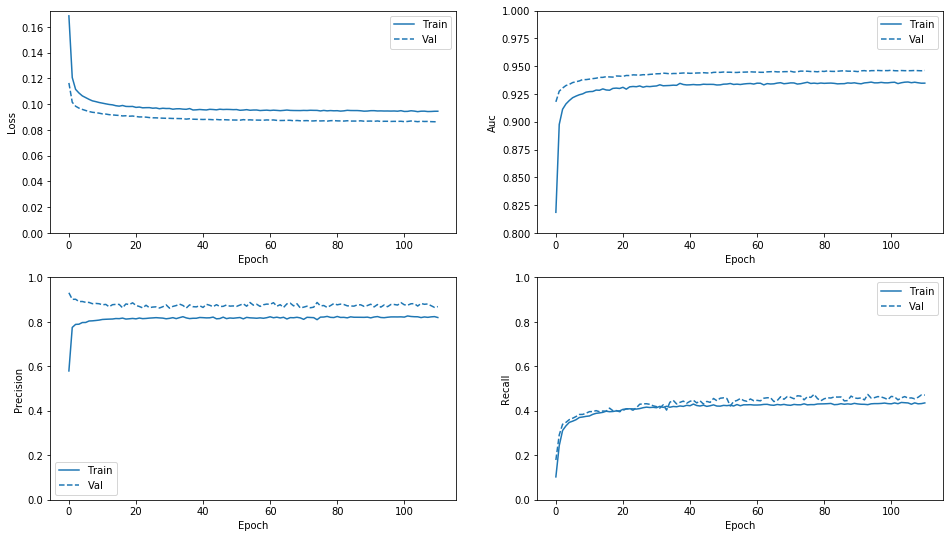

In [63]:
plot_metrics(history)

### Test Results with the ~Best Val Auc model weights

In [64]:
modelWithBias.evaluate(testX, testY)

3007/3007 [==============================] - 2s 699us/step - loss: 0.0901 - tp: 2022.0000 - fp: 288.0000 - tn: 91467.0000 - fn: 2444.0000 - accuracy: 0.9716 - precision: 0.8753 - recall: 0.4528 - auc: 0.9405


[0.09010910242795944,
 2022.0,
 288.0,
 91467.0,
 2444.0,
 0.9716070294380188,
 0.8753246665000916,
 0.4527541399002075,
 0.9404749274253845]

Legitimate Transactions Detected (True Negatives):  91467
Legitimate Transactions Incorrectly Detected (False Positives):  288
Fraudulent Transactions Missed (False Negatives):  2444
Fraudulent Transactions Detected (True Positives):  2022
Total Fraudulent Transactions:  4466


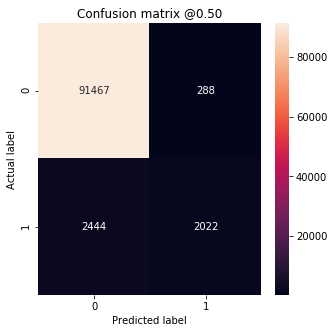

In [65]:
testPredictions = modelWithBias.predict(testX)
plot_cm(testY, testPredictions)

### Test Results with the Best Val Precision weights

In [66]:
modelWithBias.load_weights(filepath) 
modelWithBias.evaluate(testX, testY)

3007/3007 [==============================] - 2s 705us/step - loss: 0.1197 - tp: 784.0000 - fp: 69.0000 - tn: 91686.0000 - fn: 3682.0000 - accuracy: 0.9610 - precision: 0.9191 - recall: 0.1755 - auc: 0.9116


[0.11973942816257477,
 784.0,
 69.0,
 91686.0,
 3682.0,
 0.961016833782196,
 0.919109046459198,
 0.17554858326911926,
 0.9115636944770813]

Legitimate Transactions Detected (True Negatives):  91686
Legitimate Transactions Incorrectly Detected (False Positives):  69
Fraudulent Transactions Missed (False Negatives):  3682
Fraudulent Transactions Detected (True Positives):  784
Total Fraudulent Transactions:  4466


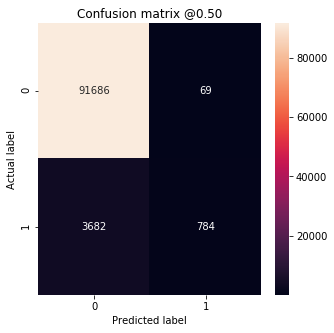

In [67]:
testPredictions = modelWithBias.predict(testX)
plot_cm(testY, testPredictions)

## Model with explicit bias setting and class weights

### Class weight calculations

In [68]:
weight_for_0 = (1 / neg)*(total)/2.0 
weight_for_1 = (1 / pos)*(total)/2.0

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for class 0: {:.2f}'.format(weight_for_0))
print('Weight for class 1: {:.2f}'.format(weight_for_1))

Weight for class 0: 0.52
Weight for class 1: 10.89


In [69]:
EPOCHS = 500
BATCH_SIZE = 2048

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_auc', 
    verbose=1,
    patience=10,
    mode='max',
    restore_best_weights=True)


# filepath = './checkpoints_monitorValAccuracy/my_checkpoint'

# monitorValAccuracy = tf.keras.callbacks.ModelCheckpoint(
#                     filepath, monitor='val_Accuracy', verbose=1, save_best_only=True,
#                     save_weights_only=True, mode='max', save_freq='epoch')

filepath = './checkpoints_monitorValPrecision_weighted_model/my_checkpoint'
monitorValPrecision = tf.keras.callbacks.ModelCheckpoint(
                    filepath, monitor='val_precision', verbose=1, save_best_only=True,
                    save_weights_only=True, mode='max', save_freq='epoch')

In [70]:
weighted_model = BinaryClassification(units=32, output_bias=initial_bias)

weighted_model.compile(optimizer=tf.keras.optimizers.Adam(lr=1e-3),
                  loss=tf.keras.losses.BinaryCrossentropy(),
                  metrics=METRICS)

In [71]:
weighted_history = weighted_model.fit(
    trainX,
    trainY,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=(valX, valY), 
    verbose=1, 
    callbacks = [early_stopping, monitorValPrecision],
    class_weight=class_weight)

Epoch 1/500
186/188 [============================>.] - ETA: 0s - loss: 0.6192 - tp: 10244.0000 - fp: 45512.0000 - tn: 409738.0000 - fn: 11655.0000 - accuracy: 0.8802 - precision: 0.1837 - recall: 0.4678 - auc: 0.7837
Epoch 00001: val_precision improved from -inf to 0.20345, saving model to ./checkpoints_monitorValPrecision_weighted_model/my_checkpoint
188/188 [==============================] - 1s 7ms/step - loss: 0.6172 - tp: 10375.0000 - fp: 46127.0000 - tn: 412900.0000 - fn: 11705.0000 - accuracy: 0.8798 - precision: 0.1836 - recall: 0.4699 - auc: 0.7843 - val_loss: 0.3618 - val_tp: 3046.0000 - val_fp: 11926.0000 - val_tn: 61509.0000 - val_fn: 496.0000 - val_accuracy: 0.8386 - val_precision: 0.2034 - val_recall: 0.8600 - val_auc: 0.9199
Epoch 2/500
186/188 [============================>.] - ETA: 0s - loss: 0.4197 - tp: 13754.0000 - fp: 57496.0000 - tn: 305989.0000 - fn: 3689.0000 - accuracy: 0.8394 - precision: 0.1930 - recall: 0.7885 - auc: 0.8953
Epoch 00002: val_precision improved

181/188 [===========================>..] - ETA: 0s - loss: 0.3446 - tp: 14036.0000 - fp: 38711.0000 - tn: 314981.0000 - fn: 2960.0000 - accuracy: 0.8876 - precision: 0.2661 - recall: 0.8258 - auc: 0.9287
Epoch 00012: val_precision did not improve from 0.28287
188/188 [==============================] - 1s 4ms/step - loss: 0.3443 - tp: 14547.0000 - fp: 40204.0000 - tn: 327068.0000 - fn: 3067.0000 - accuracy: 0.8876 - precision: 0.2657 - recall: 0.8259 - auc: 0.9286 - val_loss: 0.2996 - val_tp: 3071.0000 - val_fp: 8145.0000 - val_tn: 65290.0000 - val_fn: 471.0000 - val_accuracy: 0.8881 - val_precision: 0.2738 - val_recall: 0.8670 - val_auc: 0.9399
Epoch 13/500
174/188 [==========================>...] - ETA: 0s - loss: 0.3430 - tp: 13473.0000 - fp: 36650.0000 - tn: 303386.0000 - fn: 2843.0000 - accuracy: 0.8892 - precision: 0.2688 - recall: 0.8258 - auc: 0.9292
Epoch 00013: val_precision did not improve from 0.28287
188/188 [==============================] - 1s 4ms/step - loss: 0.3434 - tp

Epoch 24/500
184/188 [============================>.] - ETA: 0s - loss: 0.3256 - tp: 14444.0000 - fp: 36417.0000 - tn: 323164.0000 - fn: 2807.0000 - accuracy: 0.8959 - precision: 0.2840 - recall: 0.8373 - auc: 0.9355
Epoch 00024: val_precision did not improve from 0.30686
188/188 [==============================] - 1s 4ms/step - loss: 0.3256 - tp: 14751.0000 - fp: 37279.0000 - tn: 329993.0000 - fn: 2863.0000 - accuracy: 0.8957 - precision: 0.2835 - recall: 0.8375 - auc: 0.9355 - val_loss: 0.2900 - val_tp: 3101.0000 - val_fp: 7583.0000 - val_tn: 65852.0000 - val_fn: 441.0000 - val_accuracy: 0.8958 - val_precision: 0.2902 - val_recall: 0.8755 - val_auc: 0.9446
Epoch 25/500
183/188 [============================>.] - ETA: 0s - loss: 0.3256 - tp: 14401.0000 - fp: 36185.0000 - tn: 321427.0000 - fn: 2771.0000 - accuracy: 0.8961 - precision: 0.2847 - recall: 0.8386 - auc: 0.9357
Epoch 00025: val_precision did not improve from 0.30686
188/188 [==============================] - 1s 4ms/step - loss

177/188 [===========================>..] - ETA: 0s - loss: 0.3196 - tp: 13932.0000 - fp: 34225.0000 - tn: 311690.0000 - fn: 2649.0000 - accuracy: 0.8983 - precision: 0.2893 - recall: 0.8402 - auc: 0.9379
Epoch 00036: val_precision did not improve from 0.30686
188/188 [==============================] - 1s 4ms/step - loss: 0.3194 - tp: 14811.0000 - fp: 36326.0000 - tn: 330946.0000 - fn: 2803.0000 - accuracy: 0.8983 - precision: 0.2896 - recall: 0.8409 - auc: 0.9381 - val_loss: 0.2930 - val_tp: 3115.0000 - val_fp: 7635.0000 - val_tn: 65800.0000 - val_fn: 427.0000 - val_accuracy: 0.8953 - val_precision: 0.2898 - val_recall: 0.8794 - val_auc: 0.9468
Epoch 37/500
183/188 [============================>.] - ETA: 0s - loss: 0.3186 - tp: 14536.0000 - fp: 35688.0000 - tn: 321908.0000 - fn: 2652.0000 - accuracy: 0.8977 - precision: 0.2894 - recall: 0.8457 - auc: 0.9387
Epoch 00037: val_precision improved from 0.30686 to 0.31322, saving model to ./checkpoints_monitorValPrecision_weighted_model/my_c

173/188 [==========================>...] - ETA: 0s - loss: 0.3135 - tp: 13724.0000 - fp: 32714.0000 - tn: 305375.0000 - fn: 2491.0000 - accuracy: 0.9006 - precision: 0.2955 - recall: 0.8464 - auc: 0.9404
Epoch 00048: val_precision did not improve from 0.31430
188/188 [==============================] - 1s 4ms/step - loss: 0.3140 - tp: 14897.0000 - fp: 35562.0000 - tn: 331710.0000 - fn: 2717.0000 - accuracy: 0.9005 - precision: 0.2952 - recall: 0.8457 - auc: 0.9402 - val_loss: 0.2819 - val_tp: 3106.0000 - val_fp: 7171.0000 - val_tn: 66264.0000 - val_fn: 436.0000 - val_accuracy: 0.9012 - val_precision: 0.3022 - val_recall: 0.8769 - val_auc: 0.9485
Epoch 49/500
185/188 [============================>.] - ETA: 0s - loss: 0.3137 - tp: 14699.0000 - fp: 34754.0000 - tn: 326760.0000 - fn: 2667.0000 - accuracy: 0.9012 - precision: 0.2972 - recall: 0.8464 - auc: 0.9406
Epoch 00049: val_precision improved from 0.31430 to 0.32347, saving model to ./checkpoints_monitorValPrecision_weighted_model/my_c

180/188 [===========================>..] - ETA: 0s - loss: 0.3110 - tp: 14282.0000 - fp: 33338.0000 - tn: 318442.0000 - fn: 2578.0000 - accuracy: 0.9026 - precision: 0.2999 - recall: 0.8471 - auc: 0.9418
Epoch 00060: val_precision did not improve from 0.32347
188/188 [==============================] - 1s 4ms/step - loss: 0.3116 - tp: 14910.0000 - fp: 34931.0000 - tn: 332341.0000 - fn: 2704.0000 - accuracy: 0.9022 - precision: 0.2992 - recall: 0.8465 - auc: 0.9415 - val_loss: 0.2910 - val_tp: 3128.0000 - val_fp: 7534.0000 - val_tn: 65901.0000 - val_fn: 414.0000 - val_accuracy: 0.8967 - val_precision: 0.2934 - val_recall: 0.8831 - val_auc: 0.9489
Epoch 61/500
183/188 [============================>.] - ETA: 0s - loss: 0.3134 - tp: 14523.0000 - fp: 34292.0000 - tn: 323360.0000 - fn: 2609.0000 - accuracy: 0.9015 - precision: 0.2975 - recall: 0.8477 - auc: 0.9405
Epoch 00061: val_precision improved from 0.32347 to 0.32512, saving model to ./checkpoints_monitorValPrecision_weighted_model/my_c

188/188 [==============================] - ETA: 0s - loss: 0.3115 - tp: 14925.0000 - fp: 35103.0000 - tn: 332169.0000 - fn: 2689.0000 - accuracy: 0.9018 - precision: 0.2983 - recall: 0.8473 - auc: 0.9415
Epoch 00072: val_precision did not improve from 0.32512
188/188 [==============================] - 1s 4ms/step - loss: 0.3115 - tp: 14925.0000 - fp: 35103.0000 - tn: 332169.0000 - fn: 2689.0000 - accuracy: 0.9018 - precision: 0.2983 - recall: 0.8473 - auc: 0.9415 - val_loss: 0.2917 - val_tp: 3131.0000 - val_fp: 7457.0000 - val_tn: 65978.0000 - val_fn: 411.0000 - val_accuracy: 0.8978 - val_precision: 0.2957 - val_recall: 0.8840 - val_auc: 0.9496
Epoch 73/500
175/188 [==========================>...] - ETA: 0s - loss: 0.3117 - tp: 13867.0000 - fp: 32868.0000 - tn: 309153.0000 - fn: 2512.0000 - accuracy: 0.9013 - precision: 0.2967 - recall: 0.8466 - auc: 0.9415
Epoch 00073: val_precision did not improve from 0.32512
188/188 [==============================] - 1s 4ms/step - loss: 0.3107 - tp

188/188 [==============================] - ETA: 0s - loss: 0.3092 - tp: 14942.0000 - fp: 34745.0000 - tn: 332527.0000 - fn: 2672.0000 - accuracy: 0.9028 - precision: 0.3007 - recall: 0.8483 - auc: 0.9423
Epoch 00084: val_precision did not improve from 0.32946
188/188 [==============================] - 1s 4ms/step - loss: 0.3092 - tp: 14942.0000 - fp: 34745.0000 - tn: 332527.0000 - fn: 2672.0000 - accuracy: 0.9028 - precision: 0.3007 - recall: 0.8483 - auc: 0.9423 - val_loss: 0.2692 - val_tp: 3100.0000 - val_fp: 6728.0000 - val_tn: 66707.0000 - val_fn: 442.0000 - val_accuracy: 0.9069 - val_precision: 0.3154 - val_recall: 0.8752 - val_auc: 0.9503
Epoch 85/500
173/188 [==========================>...] - ETA: 0s - loss: 0.3089 - tp: 13775.0000 - fp: 32025.0000 - tn: 306094.0000 - fn: 2410.0000 - accuracy: 0.9028 - precision: 0.3008 - recall: 0.8511 - auc: 0.9422
Epoch 00085: val_precision did not improve from 0.32946
188/188 [==============================] - 1s 4ms/step - loss: 0.3091 - tp

182/188 [============================>.] - ETA: 0s - loss: 0.3101 - tp: 14517.0000 - fp: 33801.0000 - tn: 321871.0000 - fn: 2547.0000 - accuracy: 0.9025 - precision: 0.3004 - recall: 0.8507 - auc: 0.9421
Epoch 00096: val_precision did not improve from 0.32946
188/188 [==============================] - 1s 4ms/step - loss: 0.3096 - tp: 14988.0000 - fp: 34866.0000 - tn: 332406.0000 - fn: 2626.0000 - accuracy: 0.9026 - precision: 0.3006 - recall: 0.8509 - auc: 0.9422 - val_loss: 0.2760 - val_tp: 3111.0000 - val_fp: 6837.0000 - val_tn: 66598.0000 - val_fn: 431.0000 - val_accuracy: 0.9056 - val_precision: 0.3127 - val_recall: 0.8783 - val_auc: 0.9507
Epoch 97/500
186/188 [============================>.] - ETA: 0s - loss: 0.3091 - tp: 14780.0000 - fp: 34215.0000 - tn: 329307.0000 - fn: 2626.0000 - accuracy: 0.9033 - precision: 0.3017 - recall: 0.8491 - auc: 0.9424
Epoch 00097: val_precision improved from 0.32946 to 0.33387, saving model to ./checkpoints_monitorValPrecision_weighted_model/my_c

179/188 [===========================>..] - ETA: 0s - loss: 0.3099 - tp: 14233.0000 - fp: 33076.0000 - tn: 316718.0000 - fn: 2565.0000 - accuracy: 0.9028 - precision: 0.3009 - recall: 0.8473 - auc: 0.9421
Epoch 00108: val_precision did not improve from 0.33387
188/188 [==============================] - 1s 4ms/step - loss: 0.3093 - tp: 14931.0000 - fp: 34617.0000 - tn: 332655.0000 - fn: 2683.0000 - accuracy: 0.9031 - precision: 0.3013 - recall: 0.8477 - auc: 0.9423 - val_loss: 0.2648 - val_tp: 3094.0000 - val_fp: 6264.0000 - val_tn: 67171.0000 - val_fn: 448.0000 - val_accuracy: 0.9128 - val_precision: 0.3306 - val_recall: 0.8735 - val_auc: 0.9508
Epoch 109/500
187/188 [============================>.] - ETA: 0s - loss: 0.3081 - tp: 14902.0000 - fp: 34097.0000 - tn: 331363.0000 - fn: 2614.0000 - accuracy: 0.9041 - precision: 0.3041 - recall: 0.8508 - auc: 0.9427
Epoch 00109: val_precision did not improve from 0.33387
188/188 [==============================] - 1s 4ms/step - loss: 0.3081 - t

188/188 [==============================] - ETA: 0s - loss: 0.3075 - tp: 14942.0000 - fp: 34099.0000 - tn: 333173.0000 - fn: 2672.0000 - accuracy: 0.9045 - precision: 0.3047 - recall: 0.8483 - auc: 0.9427
Epoch 00120: val_precision did not improve from 0.33387
188/188 [==============================] - 1s 4ms/step - loss: 0.3075 - tp: 14942.0000 - fp: 34099.0000 - tn: 333173.0000 - fn: 2672.0000 - accuracy: 0.9045 - precision: 0.3047 - recall: 0.8483 - auc: 0.9427 - val_loss: 0.2710 - val_tp: 3108.0000 - val_fp: 6535.0000 - val_tn: 66900.0000 - val_fn: 434.0000 - val_accuracy: 0.9095 - val_precision: 0.3223 - val_recall: 0.8775 - val_auc: 0.9511
Epoch 121/500
176/188 [===========================>..] - ETA: 0s - loss: 0.3057 - tp: 14042.0000 - fp: 32192.0000 - tn: 311788.0000 - fn: 2426.0000 - accuracy: 0.9040 - precision: 0.3037 - recall: 0.8527 - auc: 0.9437
Epoch 00121: val_precision did not improve from 0.33387
188/188 [==============================] - 1s 4ms/step - loss: 0.3063 - t

183/188 [============================>.] - ETA: 0s - loss: 0.3044 - tp: 14577.0000 - fp: 33008.0000 - tn: 324621.0000 - fn: 2578.0000 - accuracy: 0.9050 - precision: 0.3063 - recall: 0.8497 - auc: 0.9441
Epoch 00132: val_precision did not improve from 0.33387
188/188 [==============================] - 1s 4ms/step - loss: 0.3047 - tp: 14975.0000 - fp: 34039.0000 - tn: 333233.0000 - fn: 2639.0000 - accuracy: 0.9047 - precision: 0.3055 - recall: 0.8502 - auc: 0.9440 - val_loss: 0.2750 - val_tp: 3122.0000 - val_fp: 7085.0000 - val_tn: 66350.0000 - val_fn: 420.0000 - val_accuracy: 0.9025 - val_precision: 0.3059 - val_recall: 0.8814 - val_auc: 0.9511
Epoch 133/500
184/188 [============================>.] - ETA: 0s - loss: 0.3061 - tp: 14643.0000 - fp: 33501.0000 - tn: 326107.0000 - fn: 2581.0000 - accuracy: 0.9042 - precision: 0.3042 - recall: 0.8502 - auc: 0.9434
Epoch 00133: val_precision did not improve from 0.33387
188/188 [==============================] - 1s 4ms/step - loss: 0.3063 - t

176/188 [===========================>..] - ETA: 0s - loss: 0.3056 - tp: 14052.0000 - fp: 31918.0000 - tn: 312029.0000 - fn: 2449.0000 - accuracy: 0.9047 - precision: 0.3057 - recall: 0.8516 - auc: 0.9436
Epoch 00144: val_precision did not improve from 0.33687
188/188 [==============================] - 1s 4ms/step - loss: 0.3065 - tp: 14982.0000 - fp: 34134.0000 - tn: 333138.0000 - fn: 2632.0000 - accuracy: 0.9045 - precision: 0.3050 - recall: 0.8506 - auc: 0.9432 - val_loss: 0.2731 - val_tp: 3113.0000 - val_fp: 6715.0000 - val_tn: 66720.0000 - val_fn: 429.0000 - val_accuracy: 0.9072 - val_precision: 0.3167 - val_recall: 0.8789 - val_auc: 0.9515
Epoch 145/500
187/188 [============================>.] - ETA: 0s - loss: 0.3066 - tp: 14891.0000 - fp: 33869.0000 - tn: 331595.0000 - fn: 2621.0000 - accuracy: 0.9047 - precision: 0.3054 - recall: 0.8503 - auc: 0.9432
Epoch 00145: val_precision did not improve from 0.33687
188/188 [==============================] - 1s 4ms/step - loss: 0.3066 - t

185/188 [============================>.] - ETA: 0s - loss: 0.3045 - tp: 14762.0000 - fp: 33558.0000 - tn: 327981.0000 - fn: 2579.0000 - accuracy: 0.9046 - precision: 0.3055 - recall: 0.8513 - auc: 0.9440
Epoch 00156: val_precision did not improve from 0.33687
188/188 [==============================] - 1s 4ms/step - loss: 0.3048 - tp: 14989.0000 - fp: 34120.0000 - tn: 333152.0000 - fn: 2625.0000 - accuracy: 0.9045 - precision: 0.3052 - recall: 0.8510 - auc: 0.9439 - val_loss: 0.2702 - val_tp: 3113.0000 - val_fp: 6539.0000 - val_tn: 66896.0000 - val_fn: 429.0000 - val_accuracy: 0.9095 - val_precision: 0.3225 - val_recall: 0.8789 - val_auc: 0.9518
Epoch 157/500
186/188 [============================>.] - ETA: 0s - loss: 0.3051 - tp: 14804.0000 - fp: 33326.0000 - tn: 330191.0000 - fn: 2607.0000 - accuracy: 0.9057 - precision: 0.3076 - recall: 0.8503 - auc: 0.9438
Epoch 00157: val_precision did not improve from 0.33687
188/188 [==============================] - 1s 4ms/step - loss: 0.3049 - t

187/188 [============================>.] - ETA: 0s - loss: 0.3050 - tp: 14885.0000 - fp: 33604.0000 - tn: 331856.0000 - fn: 2631.0000 - accuracy: 0.9054 - precision: 0.3070 - recall: 0.8498 - auc: 0.9436
Epoch 00168: val_precision did not improve from 0.34380
188/188 [==============================] - 1s 4ms/step - loss: 0.3051 - tp: 14966.0000 - fp: 33767.0000 - tn: 333505.0000 - fn: 2648.0000 - accuracy: 0.9054 - precision: 0.3071 - recall: 0.8497 - auc: 0.9436 - val_loss: 0.2666 - val_tp: 3102.0000 - val_fp: 6502.0000 - val_tn: 66933.0000 - val_fn: 440.0000 - val_accuracy: 0.9098 - val_precision: 0.3230 - val_recall: 0.8758 - val_auc: 0.9519
Epoch 169/500
183/188 [============================>.] - ETA: 0s - loss: 0.3052 - tp: 14618.0000 - fp: 32955.0000 - tn: 324673.0000 - fn: 2538.0000 - accuracy: 0.9053 - precision: 0.3073 - recall: 0.8521 - auc: 0.9437
Epoch 00169: val_precision did not improve from 0.34380
188/188 [==============================] - 1s 4ms/step - loss: 0.3055 - t

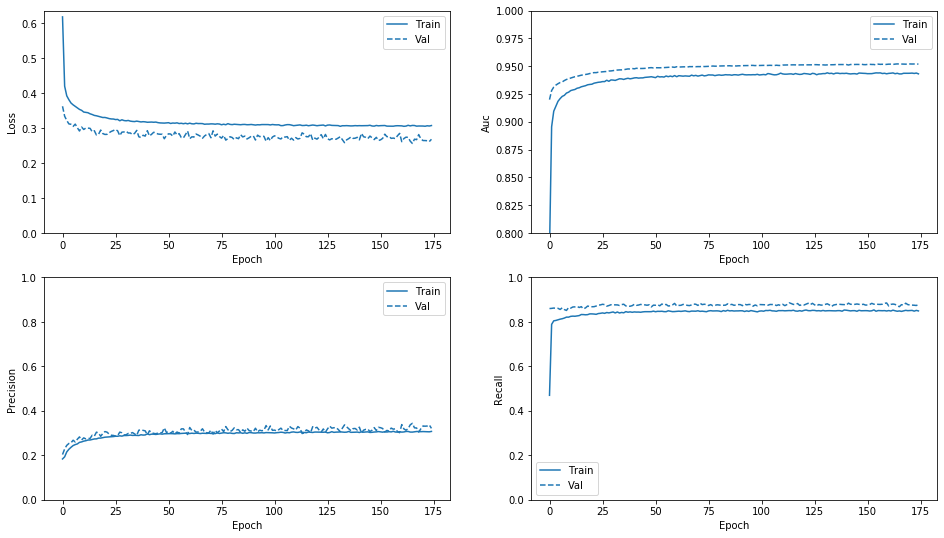

In [72]:
plot_metrics(weighted_history)

### Test Results with the ~Best Val Auc model weights

In [73]:
weighted_model.evaluate(testX, testY)

3007/3007 [==============================] - 2s 696us/step - loss: 0.2641 - tp: 3821.0000 - fp: 7664.0000 - tn: 84091.0000 - fn: 645.0000 - accuracy: 0.9136 - precision: 0.3327 - recall: 0.8556 - auc: 0.9478


[0.26410940289497375,
 3821.0,
 7664.0,
 84091.0,
 645.0,
 0.9136466979980469,
 0.3326948285102844,
 0.855575442314148,
 0.9477506875991821]

Legitimate Transactions Detected (True Negatives):  84091
Legitimate Transactions Incorrectly Detected (False Positives):  7664
Fraudulent Transactions Missed (False Negatives):  645
Fraudulent Transactions Detected (True Positives):  3821
Total Fraudulent Transactions:  4466


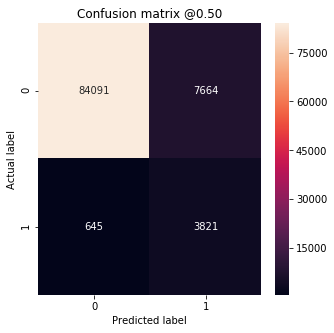

In [74]:
testPredictions = weighted_model.predict(testX)
plot_cm(testY, testPredictions)

### Test Results with the Best Val Precision weights

In [75]:
weighted_model.load_weights(filepath) 
weighted_model.evaluate(testX, testY)

3007/3007 [==============================] - 2s 701us/step - loss: 0.2576 - tp: 3804.0000 - fp: 7386.0000 - tn: 84369.0000 - fn: 662.0000 - accuracy: 0.9164 - precision: 0.3399 - recall: 0.8518 - auc: 0.9477


[0.25759273767471313,
 3804.0,
 7386.0,
 84369.0,
 662.0,
 0.9163591861724854,
 0.3399463891983032,
 0.8517689108848572,
 0.9477064609527588]

Legitimate Transactions Detected (True Negatives):  84369
Legitimate Transactions Incorrectly Detected (False Positives):  7386
Fraudulent Transactions Missed (False Negatives):  662
Fraudulent Transactions Detected (True Positives):  3804
Total Fraudulent Transactions:  4466


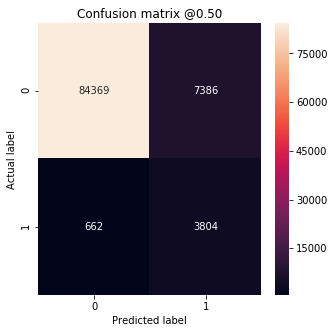

In [76]:
testPredictions = weighted_model.predict(testX)
plot_cm(testY, testPredictions)

## Oversampled

In [77]:
posIndex = train_dataset[train_dataset['labelBinary']==1].index
negIndex = train_dataset[train_dataset['labelBinary']==0].index

In [78]:
totalExamples = len(train_dataset)

In [79]:
sampledPosIndex = np.random.choice(posIndex, totalExamples//2)
sampledNegIndex = np.random.choice(negIndex, totalExamples//2)

In [80]:
sampledPosTrainDataset = train_dataset.loc[sampledPosIndex]

In [81]:
sampledNegTrainDataset = train_dataset.loc[sampledNegIndex]

In [82]:
sampledNegTrainDataset.shape

(192443, 53)

In [83]:
sampledNegTrainDataset.shape

(192443, 53)

In [84]:
overSampledTrainDataset = pd.concat([sampledPosTrainDataset,sampledNegTrainDataset], axis = 0)


In [97]:
overSampledTrainDataset.reset_index(inplace = True)
os_val_dataset = overSampledTrainDataset.sample(frac=0.2,random_state=0)
os_trainX = overSampledTrainDataset[featureCols].values
os_trainY = overSampledTrainDataset['labelBinary'].values

os_trainX, os_trainY = shuffle(os_trainX, os_trainY)

os_valX = os_val_dataset[featureCols].values
os_valY = os_val_dataset['labelBinary'].values

testX = test_dataset[featureCols].values
testY = test_dataset['labelBinary'].values

overSampledmodel = BinaryClassification(units=32)
overSampledmodel.compile(optimizer=tf.keras.optimizers.Adam(lr=1e-3),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=METRICS)



In [98]:
EPOCHS = 500
BATCH_SIZE = 2048

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_auc', 
    verbose=1,
    patience=10,
    mode='max',
    restore_best_weights=True)


filepath = './checkpoints_monitorValAccuracy_overSampledmodel/my_checkpoint'

monitorValAccuracy = tf.keras.callbacks.ModelCheckpoint(
                    filepath, monitor='val_accuracy', verbose=1, save_best_only=True,
                    save_weights_only=True, mode='max', save_freq='epoch')


In [99]:
overSampledmodel_history = overSampledmodel.fit(
    os_trainX,
    os_trainY,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=(os_valX, os_valY), 
    verbose=1, 
    callbacks = [early_stopping, monitorValAccuracy])

Epoch 1/500
186/188 [============================>.] - ETA: 0s - loss: 0.5511 - tp: 175885.0000 - fp: 57939.0000 - tn: 170679.0000 - fn: 53402.0000 - accuracy: 0.7568 - precision: 0.7522 - recall: 0.7671 - auc: 0.8423
Epoch 00001: val_accuracy improved from -inf to 0.86079, saving model to ./checkpoints_monitorValAccuracy_overSampledmodel/my_checkpoint
188/188 [==============================] - 1s 7ms/step - loss: 0.5496 - tp: 177519.0000 - fp: 58274.0000 - tn: 172362.0000 - fn: 53708.0000 - accuracy: 0.7575 - precision: 0.7529 - recall: 0.7677 - auc: 0.8430 - val_loss: 0.3644 - val_tp: 33669.0000 - val_fp: 5601.0000 - val_tn: 32592.0000 - val_fn: 5115.0000 - val_accuracy: 0.8608 - val_precision: 0.8574 - val_recall: 0.8681 - val_auc: 0.9280
Epoch 2/500
188/188 [==============================] - ETA: 0s - loss: 0.3838 - tp: 162251.0000 - fp: 30603.0000 - tn: 161840.0000 - fn: 30192.0000 - accuracy: 0.8420 - precision: 0.8413 - recall: 0.8431 - auc: 0.9130
Epoch 00002: val_accuracy impr

Epoch 12/500
175/188 [==========================>...] - ETA: 0s - loss: 0.3199 - tp: 153193.0000 - fp: 19234.0000 - tn: 159948.0000 - fn: 26025.0000 - accuracy: 0.8737 - precision: 0.8885 - recall: 0.8548 - auc: 0.9371
Epoch 00012: val_accuracy did not improve from 0.88367
188/188 [==============================] - 1s 4ms/step - loss: 0.3198 - tp: 164474.0000 - fp: 20633.0000 - tn: 171810.0000 - fn: 27969.0000 - accuracy: 0.8737 - precision: 0.8885 - recall: 0.8547 - auc: 0.9372 - val_loss: 0.2967 - val_tp: 33708.0000 - val_fp: 3934.0000 - val_tn: 34259.0000 - val_fn: 5076.0000 - val_accuracy: 0.8830 - val_precision: 0.8955 - val_recall: 0.8691 - val_auc: 0.9451
Epoch 13/500
176/188 [===========================>..] - ETA: 0s - loss: 0.3187 - tp: 154059.0000 - fp: 19082.0000 - tn: 161238.0000 - fn: 26069.0000 - accuracy: 0.8747 - precision: 0.8898 - recall: 0.8553 - auc: 0.9377
Epoch 00013: val_accuracy improved from 0.88367 to 0.88408, saving model to ./checkpoints_monitorValAccuracy_o

Epoch 24/500
179/188 [===========================>..] - ETA: 0s - loss: 0.3115 - tp: 156687.0000 - fp: 18314.0000 - tn: 165007.0000 - fn: 26584.0000 - accuracy: 0.8775 - precision: 0.8953 - recall: 0.8549 - auc: 0.9406
Epoch 00024: val_accuracy did not improve from 0.88623
188/188 [==============================] - 1s 4ms/step - loss: 0.3119 - tp: 164523.0000 - fp: 19259.0000 - tn: 173184.0000 - fn: 27920.0000 - accuracy: 0.8774 - precision: 0.8952 - recall: 0.8549 - auc: 0.9404 - val_loss: 0.2894 - val_tp: 33710.0000 - val_fp: 3699.0000 - val_tn: 34494.0000 - val_fn: 5074.0000 - val_accuracy: 0.8860 - val_precision: 0.9011 - val_recall: 0.8692 - val_auc: 0.9478
Epoch 25/500
173/188 [==========================>...] - ETA: 0s - loss: 0.3113 - tp: 151545.0000 - fp: 17615.0000 - tn: 159458.0000 - fn: 25686.0000 - accuracy: 0.8778 - precision: 0.8959 - recall: 0.8551 - auc: 0.9407
Epoch 00025: val_accuracy did not improve from 0.88623
188/188 [==============================] - 1s 4ms/step 

Epoch 36/500
179/188 [===========================>..] - ETA: 0s - loss: 0.3078 - tp: 156672.0000 - fp: 17880.0000 - tn: 165460.0000 - fn: 26580.0000 - accuracy: 0.8787 - precision: 0.8976 - recall: 0.8550 - auc: 0.9420
Epoch 00036: val_accuracy did not improve from 0.88723
188/188 [==============================] - 1s 4ms/step - loss: 0.3084 - tp: 164447.0000 - fp: 18806.0000 - tn: 173637.0000 - fn: 27996.0000 - accuracy: 0.8784 - precision: 0.8974 - recall: 0.8545 - auc: 0.9417 - val_loss: 0.2859 - val_tp: 33626.0000 - val_fp: 3550.0000 - val_tn: 34643.0000 - val_fn: 5158.0000 - val_accuracy: 0.8869 - val_precision: 0.9045 - val_recall: 0.8670 - val_auc: 0.9490
Epoch 37/500
175/188 [==========================>...] - ETA: 0s - loss: 0.3083 - tp: 152971.0000 - fp: 17353.0000 - tn: 161894.0000 - fn: 26182.0000 - accuracy: 0.8785 - precision: 0.8981 - recall: 0.8539 - auc: 0.9418
Epoch 00037: val_accuracy did not improve from 0.88723
188/188 [==============================] - 1s 4ms/step 

Epoch 48/500
188/188 [==============================] - ETA: 0s - loss: 0.3075 - tp: 164568.0000 - fp: 18565.0000 - tn: 173878.0000 - fn: 27875.0000 - accuracy: 0.8793 - precision: 0.8986 - recall: 0.8552 - auc: 0.9421
Epoch 00048: val_accuracy improved from 0.88824 to 0.88845, saving model to ./checkpoints_monitorValAccuracy_overSampledmodel/my_checkpoint
188/188 [==============================] - 1s 4ms/step - loss: 0.3075 - tp: 164568.0000 - fp: 18565.0000 - tn: 173878.0000 - fn: 27875.0000 - accuracy: 0.8793 - precision: 0.8986 - recall: 0.8552 - auc: 0.9421 - val_loss: 0.2846 - val_tp: 33715.0000 - val_fp: 3518.0000 - val_tn: 34675.0000 - val_fn: 5069.0000 - val_accuracy: 0.8884 - val_precision: 0.9055 - val_recall: 0.8693 - val_auc: 0.9495
Epoch 49/500
175/188 [==========================>...] - ETA: 0s - loss: 0.3073 - tp: 153275.0000 - fp: 17345.0000 - tn: 161876.0000 - fn: 25904.0000 - accuracy: 0.8793 - precision: 0.8983 - recall: 0.8554 - auc: 0.9422
Epoch 00049: val_accuracy

Epoch 60/500
179/188 [===========================>..] - ETA: 0s - loss: 0.3067 - tp: 156561.0000 - fp: 17614.0000 - tn: 165713.0000 - fn: 26704.0000 - accuracy: 0.8791 - precision: 0.8989 - recall: 0.8543 - auc: 0.9424
Epoch 00060: val_accuracy did not improve from 0.88890
188/188 [==============================] - 1s 4ms/step - loss: 0.3064 - tp: 164441.0000 - fp: 18491.0000 - tn: 173952.0000 - fn: 28002.0000 - accuracy: 0.8792 - precision: 0.8989 - recall: 0.8545 - auc: 0.9425 - val_loss: 0.2836 - val_tp: 33737.0000 - val_fp: 3569.0000 - val_tn: 34624.0000 - val_fn: 5047.0000 - val_accuracy: 0.8881 - val_precision: 0.9043 - val_recall: 0.8699 - val_auc: 0.9498
Epoch 61/500
183/188 [============================>.] - ETA: 0s - loss: 0.3067 - tp: 160280.0000 - fp: 17928.0000 - tn: 169518.0000 - fn: 27058.0000 - accuracy: 0.8800 - precision: 0.8994 - recall: 0.8556 - auc: 0.9426
Epoch 00061: val_accuracy did not improve from 0.88890
188/188 [==============================] - 1s 4ms/step 

174/188 [==========================>...] - ETA: 0s - loss: 0.3055 - tp: 152250.0000 - fp: 17033.0000 - tn: 161239.0000 - fn: 25830.0000 - accuracy: 0.8797 - precision: 0.8994 - recall: 0.8550 - auc: 0.9430
Epoch 00072: val_accuracy did not improve from 0.88904
188/188 [==============================] - 1s 4ms/step - loss: 0.3053 - tp: 164507.0000 - fp: 18413.0000 - tn: 174030.0000 - fn: 27936.0000 - accuracy: 0.8796 - precision: 0.8993 - recall: 0.8548 - auc: 0.9430 - val_loss: 0.2824 - val_tp: 33881.0000 - val_fp: 3694.0000 - val_tn: 34499.0000 - val_fn: 4903.0000 - val_accuracy: 0.8883 - val_precision: 0.9017 - val_recall: 0.8736 - val_auc: 0.9502
Epoch 73/500
185/188 [============================>.] - ETA: 0s - loss: 0.3059 - tp: 161990.0000 - fp: 18187.0000 - tn: 171281.0000 - fn: 27422.0000 - accuracy: 0.8796 - precision: 0.8991 - recall: 0.8552 - auc: 0.9429
Epoch 00073: val_accuracy improved from 0.88904 to 0.88919, saving model to ./checkpoints_monitorValAccuracy_overSampledmod

Epoch 84/500
185/188 [============================>.] - ETA: 0s - loss: 0.3043 - tp: 162114.0000 - fp: 17987.0000 - tn: 171510.0000 - fn: 27269.0000 - accuracy: 0.8806 - precision: 0.9001 - recall: 0.8560 - auc: 0.9434
Epoch 00084: val_accuracy did not improve from 0.88958
188/188 [==============================] - 1s 4ms/step - loss: 0.3043 - tp: 164735.0000 - fp: 18248.0000 - tn: 174195.0000 - fn: 27708.0000 - accuracy: 0.8806 - precision: 0.9003 - recall: 0.8560 - auc: 0.9433 - val_loss: 0.2813 - val_tp: 33682.0000 - val_fp: 3439.0000 - val_tn: 34754.0000 - val_fn: 5102.0000 - val_accuracy: 0.8890 - val_precision: 0.9074 - val_recall: 0.8685 - val_auc: 0.9506
Epoch 85/500
175/188 [==========================>...] - ETA: 0s - loss: 0.3052 - tp: 153290.0000 - fp: 16944.0000 - tn: 162248.0000 - fn: 25918.0000 - accuracy: 0.8804 - precision: 0.9005 - recall: 0.8554 - auc: 0.9433
Epoch 00085: val_accuracy improved from 0.88958 to 0.88992, saving model to ./checkpoints_monitorValAccuracy_o

182/188 [============================>.] - ETA: 0s - loss: 0.3040 - tp: 159493.0000 - fp: 17678.0000 - tn: 168751.0000 - fn: 26814.0000 - accuracy: 0.8806 - precision: 0.9002 - recall: 0.8561 - auc: 0.9436
Epoch 00096: val_accuracy did not improve from 0.88992
188/188 [==============================] - 1s 4ms/step - loss: 0.3043 - tp: 164749.0000 - fp: 18286.0000 - tn: 174157.0000 - fn: 27694.0000 - accuracy: 0.8805 - precision: 0.9001 - recall: 0.8561 - auc: 0.9435 - val_loss: 0.2807 - val_tp: 33806.0000 - val_fp: 3557.0000 - val_tn: 34636.0000 - val_fn: 4978.0000 - val_accuracy: 0.8891 - val_precision: 0.9048 - val_recall: 0.8716 - val_auc: 0.9509
Epoch 97/500
174/188 [==========================>...] - ETA: 0s - loss: 0.3041 - tp: 152279.0000 - fp: 16827.0000 - tn: 161416.0000 - fn: 25830.0000 - accuracy: 0.8803 - precision: 0.9005 - recall: 0.8550 - auc: 0.9435
Epoch 00097: val_accuracy did not improve from 0.88992
188/188 [==============================] - 1s 4ms/step - loss: 0.304

184/188 [============================>.] - ETA: 0s - loss: 0.3050 - tp: 161291.0000 - fp: 17771.0000 - tn: 170596.0000 - fn: 27174.0000 - accuracy: 0.8807 - precision: 0.9008 - recall: 0.8558 - auc: 0.9433
Epoch 00108: val_accuracy did not improve from 0.89021
188/188 [==============================] - 1s 4ms/step - loss: 0.3049 - tp: 164668.0000 - fp: 18143.0000 - tn: 174300.0000 - fn: 27775.0000 - accuracy: 0.8807 - precision: 0.9008 - recall: 0.8557 - auc: 0.9433 - val_loss: 0.2805 - val_tp: 33679.0000 - val_fp: 3427.0000 - val_tn: 34766.0000 - val_fn: 5105.0000 - val_accuracy: 0.8892 - val_precision: 0.9076 - val_recall: 0.8684 - val_auc: 0.9509
Epoch 109/500
177/188 [===========================>..] - ETA: 0s - loss: 0.3041 - tp: 155077.0000 - fp: 17021.0000 - tn: 164238.0000 - fn: 26160.0000 - accuracy: 0.8809 - precision: 0.9011 - recall: 0.8557 - auc: 0.9435
Epoch 00109: val_accuracy did not improve from 0.89021
188/188 [==============================] - 1s 4ms/step - loss: 0.30

176/188 [===========================>..] - ETA: 0s - loss: 0.3033 - tp: 154331.0000 - fp: 16927.0000 - tn: 163322.0000 - fn: 25868.0000 - accuracy: 0.8813 - precision: 0.9012 - recall: 0.8564 - auc: 0.9438
Epoch 00120: val_accuracy did not improve from 0.89021
188/188 [==============================] - 1s 4ms/step - loss: 0.3032 - tp: 164765.0000 - fp: 18064.0000 - tn: 174379.0000 - fn: 27678.0000 - accuracy: 0.8812 - precision: 0.9012 - recall: 0.8562 - auc: 0.9439 - val_loss: 0.2802 - val_tp: 33622.0000 - val_fp: 3322.0000 - val_tn: 34871.0000 - val_fn: 5162.0000 - val_accuracy: 0.8898 - val_precision: 0.9101 - val_recall: 0.8669 - val_auc: 0.9512
Epoch 121/500
174/188 [==========================>...] - ETA: 0s - loss: 0.3039 - tp: 152568.0000 - fp: 16770.0000 - tn: 161341.0000 - fn: 25673.0000 - accuracy: 0.8809 - precision: 0.9010 - recall: 0.8560 - auc: 0.9437
Epoch 00121: val_accuracy did not improve from 0.89021
188/188 [==============================] - 1s 4ms/step - loss: 0.30

175/188 [==========================>...] - ETA: 0s - loss: 0.3044 - tp: 153218.0000 - fp: 16849.0000 - tn: 162414.0000 - fn: 25919.0000 - accuracy: 0.8807 - precision: 0.9009 - recall: 0.8553 - auc: 0.9435
Epoch 00132: val_accuracy did not improve from 0.89036
188/188 [==============================] - 1s 4ms/step - loss: 0.3043 - tp: 164626.0000 - fp: 18114.0000 - tn: 174329.0000 - fn: 27817.0000 - accuracy: 0.8807 - precision: 0.9009 - recall: 0.8555 - auc: 0.9436 - val_loss: 0.2796 - val_tp: 33647.0000 - val_fp: 3306.0000 - val_tn: 34887.0000 - val_fn: 5137.0000 - val_accuracy: 0.8903 - val_precision: 0.9105 - val_recall: 0.8675 - val_auc: 0.9513
Epoch 133/500
185/188 [============================>.] - ETA: 0s - loss: 0.3039 - tp: 162128.0000 - fp: 17783.0000 - tn: 171684.0000 - fn: 27285.0000 - accuracy: 0.8810 - precision: 0.9012 - recall: 0.8559 - auc: 0.9438
Epoch 00133: val_accuracy did not improve from 0.89036
188/188 [==============================] - 1s 4ms/step - loss: 0.30

175/188 [==========================>...] - ETA: 0s - loss: 0.3044 - tp: 153472.0000 - fp: 16838.0000 - tn: 162257.0000 - fn: 25833.0000 - accuracy: 0.8809 - precision: 0.9011 - recall: 0.8559 - auc: 0.9436
Epoch 00144: val_accuracy did not improve from 0.89058
188/188 [==============================] - 1s 4ms/step - loss: 0.3043 - tp: 164769.0000 - fp: 18142.0000 - tn: 174301.0000 - fn: 27674.0000 - accuracy: 0.8810 - precision: 0.9008 - recall: 0.8562 - auc: 0.9436 - val_loss: 0.2797 - val_tp: 33574.0000 - val_fp: 3231.0000 - val_tn: 34962.0000 - val_fn: 5210.0000 - val_accuracy: 0.8903 - val_precision: 0.9122 - val_recall: 0.8657 - val_auc: 0.9515
Epoch 145/500
186/188 [============================>.] - ETA: 0s - loss: 0.3035 - tp: 162961.0000 - fp: 17798.0000 - tn: 172637.0000 - fn: 27532.0000 - accuracy: 0.8810 - precision: 0.9015 - recall: 0.8555 - auc: 0.9439
Epoch 00145: val_accuracy did not improve from 0.89058
188/188 [==============================] - 1s 4ms/step - loss: 0.30

Epoch 156/500
188/188 [==============================] - ETA: 0s - loss: 0.3028 - tp: 164670.0000 - fp: 18000.0000 - tn: 174443.0000 - fn: 27773.0000 - accuracy: 0.8811 - precision: 0.9015 - recall: 0.8557 - auc: 0.9440
Epoch 00156: val_accuracy did not improve from 0.89081
188/188 [==============================] - 1s 4ms/step - loss: 0.3028 - tp: 164670.0000 - fp: 18000.0000 - tn: 174443.0000 - fn: 27773.0000 - accuracy: 0.8811 - precision: 0.9015 - recall: 0.8557 - auc: 0.9440 - val_loss: 0.2789 - val_tp: 33840.0000 - val_fp: 3487.0000 - val_tn: 34706.0000 - val_fn: 4944.0000 - val_accuracy: 0.8905 - val_precision: 0.9066 - val_recall: 0.8725 - val_auc: 0.9515
Epoch 157/500
174/188 [==========================>...] - ETA: 0s - loss: 0.3034 - tp: 152703.0000 - fp: 16617.0000 - tn: 161390.0000 - fn: 25642.0000 - accuracy: 0.8814 - precision: 0.9019 - recall: 0.8562 - auc: 0.9439
Epoch 00157: val_accuracy did not improve from 0.89081
188/188 [==============================] - 1s 4ms/ste

185/188 [============================>.] - ETA: 0s - loss: 0.3030 - tp: 161981.0000 - fp: 17613.0000 - tn: 171812.0000 - fn: 27474.0000 - accuracy: 0.8810 - precision: 0.9019 - recall: 0.8550 - auc: 0.9441
Epoch 00168: val_accuracy did not improve from 0.89105
188/188 [==============================] - 1s 4ms/step - loss: 0.3029 - tp: 164570.0000 - fp: 17894.0000 - tn: 174549.0000 - fn: 27873.0000 - accuracy: 0.8811 - precision: 0.9019 - recall: 0.8552 - auc: 0.9442 - val_loss: 0.2782 - val_tp: 33884.0000 - val_fp: 3580.0000 - val_tn: 34613.0000 - val_fn: 4900.0000 - val_accuracy: 0.8898 - val_precision: 0.9044 - val_recall: 0.8737 - val_auc: 0.9517
Epoch 169/500
176/188 [===========================>..] - ETA: 0s - loss: 0.3028 - tp: 154209.0000 - fp: 16789.0000 - tn: 163494.0000 - fn: 25956.0000 - accuracy: 0.8814 - precision: 0.9018 - recall: 0.8559 - auc: 0.9440
Epoch 00169: val_accuracy did not improve from 0.89105
188/188 [==============================] - 1s 4ms/step - loss: 0.30

176/188 [===========================>..] - ETA: 0s - loss: 0.3022 - tp: 154230.0000 - fp: 16796.0000 - tn: 163545.0000 - fn: 25877.0000 - accuracy: 0.8816 - precision: 0.9018 - recall: 0.8563 - auc: 0.9444
Epoch 00180: val_accuracy did not improve from 0.89105
188/188 [==============================] - 1s 4ms/step - loss: 0.3020 - tp: 164772.0000 - fp: 17929.0000 - tn: 174514.0000 - fn: 27671.0000 - accuracy: 0.8815 - precision: 0.9019 - recall: 0.8562 - auc: 0.9444 - val_loss: 0.2776 - val_tp: 33688.0000 - val_fp: 3296.0000 - val_tn: 34897.0000 - val_fn: 5096.0000 - val_accuracy: 0.8910 - val_precision: 0.9109 - val_recall: 0.8686 - val_auc: 0.9521
Epoch 181/500
184/188 [============================>.] - ETA: 0s - loss: 0.3029 - tp: 161284.0000 - fp: 17485.0000 - tn: 170905.0000 - fn: 27158.0000 - accuracy: 0.8815 - precision: 0.9022 - recall: 0.8559 - auc: 0.9441
Epoch 00181: val_accuracy did not improve from 0.89105
188/188 [==============================] - 1s 4ms/step - loss: 0.30

182/188 [============================>.] - ETA: 0s - loss: 0.3025 - tp: 159261.0000 - fp: 17134.0000 - tn: 169256.0000 - fn: 27085.0000 - accuracy: 0.8814 - precision: 0.9029 - recall: 0.8547 - auc: 0.9443
Epoch 00192: val_accuracy did not improve from 0.89132
188/188 [==============================] - 1s 4ms/step - loss: 0.3024 - tp: 164493.0000 - fp: 17706.0000 - tn: 174737.0000 - fn: 27950.0000 - accuracy: 0.8814 - precision: 0.9028 - recall: 0.8548 - auc: 0.9443 - val_loss: 0.2773 - val_tp: 33944.0000 - val_fp: 3598.0000 - val_tn: 34595.0000 - val_fn: 4840.0000 - val_accuracy: 0.8904 - val_precision: 0.9042 - val_recall: 0.8752 - val_auc: 0.9521
Epoch 193/500
178/188 [===========================>..] - ETA: 0s - loss: 0.3026 - tp: 156209.0000 - fp: 17038.0000 - tn: 165186.0000 - fn: 26111.0000 - accuracy: 0.8816 - precision: 0.9017 - recall: 0.8568 - auc: 0.9444
Epoch 00193: val_accuracy did not improve from 0.89132
188/188 [==============================] - 1s 4ms/step - loss: 0.30

175/188 [==========================>...] - ETA: 0s - loss: 0.3024 - tp: 153323.0000 - fp: 16726.0000 - tn: 162484.0000 - fn: 25867.0000 - accuracy: 0.8812 - precision: 0.9016 - recall: 0.8556 - auc: 0.9443
Epoch 00204: val_accuracy did not improve from 0.89179
188/188 [==============================] - 1s 4ms/step - loss: 0.3021 - tp: 164645.0000 - fp: 17973.0000 - tn: 174470.0000 - fn: 27798.0000 - accuracy: 0.8811 - precision: 0.9016 - recall: 0.8556 - auc: 0.9444 - val_loss: 0.2772 - val_tp: 33993.0000 - val_fp: 3578.0000 - val_tn: 34615.0000 - val_fn: 4791.0000 - val_accuracy: 0.8913 - val_precision: 0.9048 - val_recall: 0.8765 - val_auc: 0.9522
Epoch 205/500
181/188 [===========================>..] - ETA: 0s - loss: 0.3026 - tp: 158529.0000 - fp: 17103.0000 - tn: 168246.0000 - fn: 26810.0000 - accuracy: 0.8815 - precision: 0.9026 - recall: 0.8553 - auc: 0.9444
Epoch 00205: val_accuracy did not improve from 0.89179
188/188 [==============================] - 1s 4ms/step - loss: 0.30

188/188 [==============================] - ETA: 0s - loss: 0.3019 - tp: 164657.0000 - fp: 17753.0000 - tn: 174690.0000 - fn: 27786.0000 - accuracy: 0.8817 - precision: 0.9027 - recall: 0.8556 - auc: 0.9446
Epoch 00216: val_accuracy did not improve from 0.89179
188/188 [==============================] - 1s 4ms/step - loss: 0.3019 - tp: 164657.0000 - fp: 17753.0000 - tn: 174690.0000 - fn: 27786.0000 - accuracy: 0.8817 - precision: 0.9027 - recall: 0.8556 - auc: 0.9446 - val_loss: 0.2769 - val_tp: 33744.0000 - val_fp: 3395.0000 - val_tn: 34798.0000 - val_fn: 5040.0000 - val_accuracy: 0.8904 - val_precision: 0.9086 - val_recall: 0.8700 - val_auc: 0.9523
Epoch 217/500
177/188 [===========================>..] - ETA: 0s - loss: 0.3017 - tp: 155147.0000 - fp: 16705.0000 - tn: 164533.0000 - fn: 26111.0000 - accuracy: 0.8819 - precision: 0.9028 - recall: 0.8559 - auc: 0.9446
Epoch 00217: val_accuracy did not improve from 0.89179
188/188 [==============================] - 1s 4ms/step - loss: 0.30

186/188 [============================>.] - ETA: 0s - loss: 0.3025 - tp: 162938.0000 - fp: 17532.0000 - tn: 172917.0000 - fn: 27541.0000 - accuracy: 0.8817 - precision: 0.9029 - recall: 0.8554 - auc: 0.9445
Epoch 00228: val_accuracy did not improve from 0.89179
188/188 [==============================] - 1s 4ms/step - loss: 0.3025 - tp: 164627.0000 - fp: 17722.0000 - tn: 174721.0000 - fn: 27816.0000 - accuracy: 0.8817 - precision: 0.9028 - recall: 0.8555 - auc: 0.9445 - val_loss: 0.2769 - val_tp: 33939.0000 - val_fp: 3540.0000 - val_tn: 34653.0000 - val_fn: 4845.0000 - val_accuracy: 0.8911 - val_precision: 0.9055 - val_recall: 0.8751 - val_auc: 0.9522
Epoch 229/500
173/188 [==========================>...] - ETA: 0s - loss: 0.3029 - tp: 151490.0000 - fp: 16412.0000 - tn: 160816.0000 - fn: 25586.0000 - accuracy: 0.8815 - precision: 0.9023 - recall: 0.8555 - auc: 0.9443
Epoch 00229: val_accuracy did not improve from 0.89179
188/188 [==============================] - 1s 4ms/step - loss: 0.30

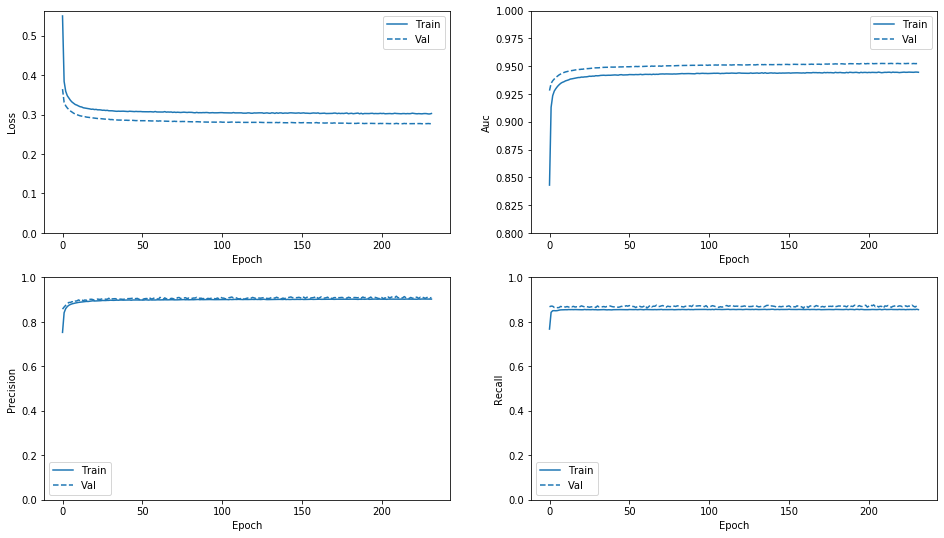

In [100]:
plot_metrics(overSampledmodel_history)

### Test Results with the ~Best Val Auc model weights

In [101]:
overSampledmodel.evaluate(testX, testY)

3007/3007 [==============================] - 2s 712us/step - loss: 0.2644 - tp: 3847.0000 - fp: 8125.0000 - tn: 83630.0000 - fn: 619.0000 - accuracy: 0.9091 - precision: 0.3213 - recall: 0.8614 - auc: 0.9484


[0.26438766717910767,
 3847.0,
 8125.0,
 83630.0,
 619.0,
 0.9091258645057678,
 0.321333110332489,
 0.8613972067832947,
 0.9483695030212402]

Legitimate Transactions Detected (True Negatives):  83630
Legitimate Transactions Incorrectly Detected (False Positives):  8125
Fraudulent Transactions Missed (False Negatives):  619
Fraudulent Transactions Detected (True Positives):  3847
Total Fraudulent Transactions:  4466


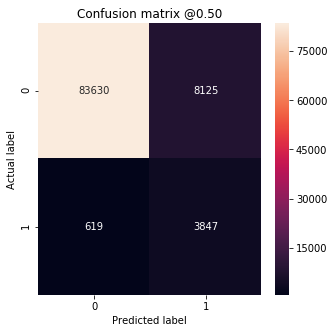

In [102]:
testPredictions = overSampledmodel.predict(testX)
plot_cm(testY, testPredictions)


### Test Results with the Best Val Accuracy model weights

In [103]:
overSampledmodel.load_weights(filepath)
overSampledmodel.evaluate(testX, testY)

3007/3007 [==============================] - 2s 685us/step - loss: 0.2678 - tp: 3852.0000 - fp: 8146.0000 - tn: 83609.0000 - fn: 614.0000 - accuracy: 0.9090 - precision: 0.3211 - recall: 0.8625 - auc: 0.9481


[0.2678135633468628,
 3852.0,
 8146.0,
 83609.0,
 614.0,
 0.9089595675468445,
 0.32105350494384766,
 0.8625168204307556,
 0.9481170177459717]

In [104]:
testPredictions = overSampledmodel.predict(testX)

Legitimate Transactions Detected (True Negatives):  83609
Legitimate Transactions Incorrectly Detected (False Positives):  8146
Fraudulent Transactions Missed (False Negatives):  614
Fraudulent Transactions Detected (True Positives):  3852
Total Fraudulent Transactions:  4466


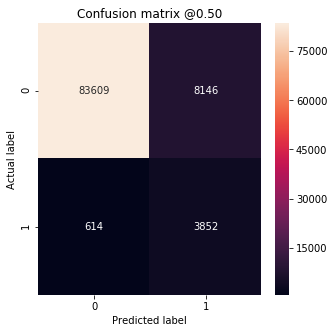

In [105]:

plot_cm(testY, testPredictions)


Further Ideas:
1. day of week of order placed might not provide the enough information to improve the results significantly but time of the day when the order was placed applied with trigonometric transformations on the time of the day might help. 
https://ianlondon.github.io/blog/encoding-cyclical-features-24hour-time/ . Transformer/BERT model uses same concept to encode positional e,bedding for each symbol in a sequence. 
2. Get a realtime reference dataset for pincodes which will provide odds of a fraudulent transaction for each pincode based on transactions happened on last 30 days or so. 
3. Get a refereence data set which will provide (x,y) for each pincode. Use it to find 10 closest pincodes and use their weighted average of respective odds of fraudulent transaction. 
4. Use NLP embedding to get an idea about which products are closer.
5. Use relative price of each products within respective category products. 
6. Ofcourse test with different values of thresholds to decide on what to use to mark each transaction. 
7. Payment type of each order night provide useful information. 

## Autoencoders

In [198]:
trainX, trainY = shuffle(trainX, trainY)
EPOCHS = 500
BATCH_SIZE = 2048

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', 
    verbose=1,
    patience=10,
    mode='min',
    restore_best_weights=True)


filepath = './checkpoints_monitorValLoss_autoencoder/my_checkpoint'

monitorValLoss = tf.keras.callbacks.ModelCheckpoint(
                    filepath, monitor='val_loss', verbose=1, save_best_only=True,
                    save_weights_only=True, mode='min', save_freq='epoch')

opt = tf.keras.optimizers.RMSprop(learning_rate=0.1)

In [199]:
class SimpleAutoEncoder(tf.keras.Model):
    def __init__(self, units1, units2, input_dim):
        super(SimpleAutoEncoder, self).__init__()
        self.encoder1 = tf.keras.layers.Dense(units1, activation="relu",
                                              kernel_regularizer=tf.keras.regularizers.l1(10e-5))
        self.encoder2 = tf.keras.layers.Dense(units2, activation="relu",
                                              kernel_regularizer=tf.keras.regularizers.l2(10e-5))
        self.decoder = tf.keras.layers.Dense(units1, activation="relu",
                                              kernel_regularizer=tf.keras.regularizers.l2(10e-5))
        self.final = tf.keras.layers.Dense(input_dim, activation=None)
    
    def call(self, inputs):
        x = self.encoder1(inputs)
        x = self.encoder2(x)
        x = self.decoder(x)
        x = self.final(x)
        return x

In [200]:
input_dim = 40
units1 = 16
units2 = 4

autoencoder = SimpleAutoEncoder(units1, units2, input_dim)

autoencoder.compile(optimizer=opt, 
                    loss='mean_squared_error', 
                    metrics=['mae', 'mse'])



In [201]:
autoencoderHistory = autoencoder.fit(trainX, trainX,
                    epochs=EPOCHS,
                    batch_size=BATCH_SIZE,
                    shuffle=True,
                    validation_data=(valX, valX),
                    verbose=1,
                    callbacks=[early_stopping, monitorValLoss])

Epoch 1/500
170/188 [==========================>...] - ETA: 0s - loss: 0.7527 - mae: 0.2780 - mse: 0.7484
Epoch 00001: val_loss improved from inf to 0.74330, saving model to ./checkpoints_monitorValLoss_autoencoder/my_checkpoint
188/188 [==============================] - 0s 2ms/step - loss: 0.7513 - mae: 0.2778 - mse: 0.7471 - val_loss: 0.7433 - val_mae: 0.2747 - val_mse: 0.7404
Epoch 2/500
176/188 [===========================>..] - ETA: 0s - loss: 0.7724 - mae: 0.2781 - mse: 0.7676
Epoch 00002: val_loss improved from 0.74330 to 0.74231, saving model to ./checkpoints_monitorValLoss_autoencoder/my_checkpoint
188/188 [==============================] - 0s 2ms/step - loss: 0.7667 - mae: 0.2779 - mse: 0.7620 - val_loss: 0.7423 - val_mae: 0.2717 - val_mse: 0.7396
Epoch 3/500
179/188 [===========================>..] - ETA: 0s - loss: 0.7835 - mae: 0.2773 - mse: 0.7790
Epoch 00003: val_loss improved from 0.74231 to 0.74102, saving model to ./checkpoints_monitorValLoss_autoencoder/my_checkpoint

In [243]:
autoencoder.load_weights(filepath)
predictions = autoencoder.predict(valX)

mse = np.mean(np.power(valX - predictions, 2), axis=1)
error_df = pd.DataFrame({'reconstruction_error': mse,
                        'true_class': valY})

In [244]:
normal_error_df.describe()

,reconstruction_error,true_class
count,367272.000000,367272.0
mean,0.677293,0.0
std,11.371609,0.0
min,0.014039,0.0
25%,0.102013,0.0
50%,0.138380,0.0
75%,0.228709,0.0
max,1973.833511,0.0


In [245]:
from sklearn.metrics import (confusion_matrix, precision_recall_curve, auc,
                             roc_curve, recall_score, classification_report, f1_score,
                             precision_recall_fscore_support)

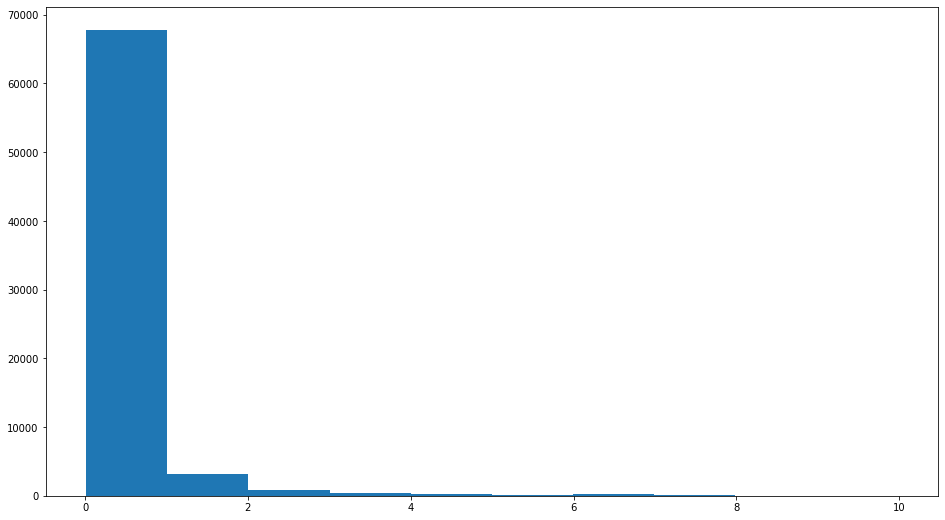

In [246]:
fig = plt.figure(figsize=(16,9))
ax = fig.add_subplot(111)
normal_error_df = error_df[(error_df['true_class']== 0) & (error_df['reconstruction_error'] < 10)]
_ = ax.hist(normal_error_df.reconstruction_error.values, bins=10)

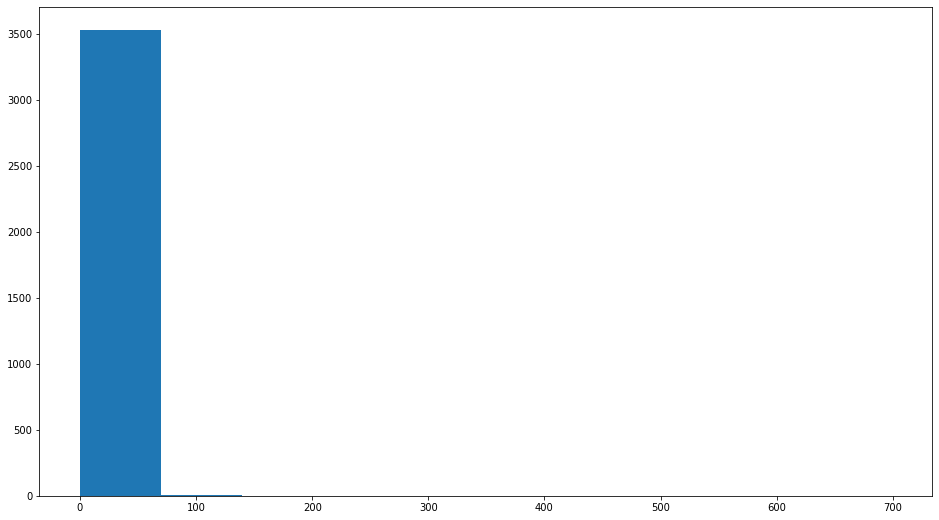

In [247]:
fig = plt.figure(figsize=(16,9))
ax = fig.add_subplot(111)
fraud_error_df = error_df[error_df['true_class'] == 1]
_ = ax.hist(fraud_error_df.reconstruction_error.values, bins=10)

In [248]:
normal_error_df = error_df[error_df['true_class']== 0]
normal_error_df.describe()

,reconstruction_error,true_class
count,73435.000000,73435.0
mean,0.693988,0.0
std,12.486181,0.0
min,0.014039,0.0
25%,0.102284,0.0
50%,0.138195,0.0
75%,0.226989,0.0
max,1973.829743,0.0


In [249]:
fraud_error_df.describe()

,reconstruction_error,true_class
count,3542.000000,3542.0
mean,1.654763,1.0
std,18.192763,0.0
min,0.031090,1.0
25%,0.131946,1.0
50%,0.199183,1.0
75%,0.482261,1.0
max,699.081287,1.0


In [255]:
predictions_test = autoencoder.predict(testX)
test_mse = np.mean(np.power(testX - predictions_test, 2), axis=1)
test_error_df = pd.DataFrame({'reconstruction_error': test_mse,
                              'true_class': testY})

Legitimate Transactions Detected (True Negatives):  70600
Legitimate Transactions Incorrectly Detected (False Positives):  21155
Fraudulent Transactions Missed (False Negatives):  2502
Fraudulent Transactions Detected (True Positives):  1964
Total Fraudulent Transactions:  4466


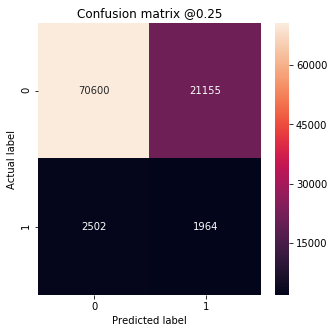

In [261]:
plot_cm(test_error_df['true_class'].values, test_error_df['reconstruction_error'].values, p=0.25)